# Homework 3 Rosini Micol


## Influenza H1N1 2009 Pandemic in Sweden

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math
import random

In [3]:
# Utils cell for creatin graphs

# Create the k-regular Cycle Graph

def create_k_regular_G(G,k,n_nodes):  
    for n in range(n_nodes):
        G.add_edge(n,((n+math.floor(k/2)) % n_nodes))
        G.add_edge(n,((n-math.ceil(k/2)) % n_nodes))

# Create a random graph with preferential attachment

def create_random_graph(G,k,n_nodes_tot):
    
    for node in range(k+1,n_nodes_tot): 
        c = k/2
        
        if node%2==1:
            c = math.floor(c)
        else node%2==0:
            c = math.ceil(c) 
            
        degree_distribution = [] #list of all the degrees of nodes
        for el in G.degree():
            degree_distribution.append(el[1])
            
        degree_probabilities = [k/sum(degree_distribution) for k in degree_distribution]
        neighbors = np.random.choice(np.arange(len(G)), p=degree_probabilities, size=c, replace=False)
        G.add_node(node)
        for neigh in neighbors:
            G.add_edge(node,neigh)
            
    avg_degree = sum(degree_distribution)/len(degree_distribution)
    
    return avg_degree

# Create a random graph with a small world model 

def create_small_world_g(G,p = 0.0023, n_nodes = 934, k_max = 8):
    
    for n in range(n_nodes):
        G.add_edge(n,((n+2) % n_nodes))
        G.add_edge(n,((n-2) % n_nodes))

    for i in range(n_nodes):
        k = 4
        for j in range(n_nodes):
            if np.random.rand() < p:
                k +=1
                G.add_edge(i,j)
                if k == k_max :
                    break
    degree_distribution = [] #list of all the degrees of nodes
    for el in G.degree():
        degree_distribution.append(el[1])

    avg_degree = sum(degree_distribution)/len(degree_distribution)

    #print('The average degree of G is:',avg_degree) 

In [54]:
# Utils cell for generic functions

def create_avg(array):
    avg = (np.sum(array, axis= 0)/len(array))
    return avg

def create_increments_from_array(array):
    increments = [array[0]]
    for i in range(1,len(array)):
        increments.append(array[i]- array[i-1])
    return increments

def create_neighbours(W):
    neighbours=[]
    for row in W:
        neighbours_node = []
        for idx, value in enumerate(list(row)):
            if value == 1:
                neighbours_node.append(idx)
        neighbours.append(neighbours_node)
    return neighbours

def check_parameter(b,r,k):
    if b < 0:
        b = 0
    elif b > 1:
        b = 1
    if r < 0:
        r = 0
    elif r > 1:
        r = 1
    
    # In order to have degree at least 4
    if k <= 3:
        k = 4
    return b,r,k

In [200]:
# Utils cell for simulations

# This function gives vaccine to people
def sim_with_vaccine(vacc_increments, i, n_nodes,to_vacc,states,n_s,n_i,n_r,tot_v):
            
                n_v = math.floor((vacc_increments[i]*n_nodes)/100)
                
                random_idx_to_vacc = random.sample(list(to_vacc), n_v)
                for index in random_idx_to_vacc:
                    if states[index] == 0:
                        n_s-=1
                    elif states[index] == 1 :
                        n_i-=1
                    else:
                        n_r-=1
                    states[index] = 3
                    tot_v += 1
                    to_vacc.remove(index) # node=index is now vaccinated
                
                return states, n_s, n_i, n_r, tot_v, n_v, to_vacc
            
# This function simulate an epidemic

def SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho, use_vaccine = 0, vacc_increments = None):
    
    W = np.array(nx.convert_matrix.to_numpy_matrix(G))
    states = np.zeros(n_nodes, dtype=int) # 'States' keeps track of all the states(0,1,2) of the nodes
    # In the initial configuration 10 agents are infected
    random_indexes = random.sample(range(0, n_nodes-1), n_infected)
    states[random_indexes] = 1
    neighbours = create_neighbours(W)
        
    epidemics = [[],[],[],[]]
    
    
    n_s = n_nodes-n_infected # Number of susceptible
    n_i = n_infected # Number of infected
    n_r = 0 # Number of recovered
    n_v = 0 # Number of people that must be vaccinated that week
    tot_v = 0 # Total number of vaccinated
    new_infected = [] # Number of new infected for each week
    new_vaccinated = [] # Number of new vaccinated for each week
    new_infected.append(n_i)
    new_vaccinated.append(0)
    
    to_vacc = list(np.arange(n_nodes)) # Nodes who still need to be vaccinated
    
    for i in range(n_steps):
        
        old_states = states.copy() # In this way nodes that were infected but become susceptible in the current week, in the week before could have infected someone else
        if use_vaccine == 1:
            
            
            states, n_s, n_i, n_r, tot_v,n_v,to_vacc = sim_with_vaccine(vacc_increments, i, n_nodes,to_vacc,states,n_s,n_i,n_r,tot_v)
            
        epidemics[0].append(n_s)
        epidemics[1].append(n_i)
        epidemics[2].append(n_r)
        epidemics[3].append(tot_v)
        new_i = 0
        
        for x in range(n_nodes):
            
            if  states[x] == 0:
                m = 0    
                for neighbour in neighbours[x]:
                    if old_states[neighbour] == 1:
                        m+=1
                
                if random.random()< (1 - (1-beta)**m):
                    states[x] = 1 
                    new_i += 1
                    n_i += 1
                    n_s -= 1

            elif states[x] == 1:
                if random.random()< rho:
                    states[x] = 2
                    n_r += 1
                    n_i -= 1
                    
        
        new_infected.append(new_i)
        new_vaccinated.append(n_v)
    
    epidemics[0].append(n_s)
    epidemics[1].append(n_i)
    epidemics[2].append(n_r)
    epidemics[3].append(tot_v)
   
    return epidemics, new_infected,new_vaccinated

# This function create the average of simulation's result of N iteration

def SIR_avg_plotting(N,function):
    epidemics_all = [] #List of lists with all the different numbers of susceptible, infected and recovered of the different weeks of the different simulations
    new_infected_all = [] # List of lists with all the different new infections of the simulations
    new_vaccinated_all = []
    for i in range(N):

        # epideic contains a list of lists with all the different number of people that are susceptible, infected and recovered for each different time-step
        epidemic,new_infected,new_vaccinated = function
        epidemics_all.append(epidemic)
        new_infected_all.append(new_infected) 
        new_vaccinated_all.append(new_vaccinated)
        
    ep = np.array(epidemics_all) # Transform the list of lists in a np.array

    new_infected_avg = create_avg(new_infected_all)
    new_vaccinated_avg = create_avg(new_vaccinated_all)
    susceptible_avg = create_avg(ep[:, 0, :])
    infected_avg = create_avg(ep[:, 1, :])
    recovered_avg = create_avg(ep[:, 2, :])
    vaccinated_avg = create_avg(ep[:, 3, :])
    return new_infected_avg,new_vaccinated_avg,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg

# This function is for simulate the H1k1 and explore the parameters

def simulation_H1N1(k_0 = 10, beta_0 = 0.3, rho_0 = 0.6, delta_br = 0.1, delta_k = 1, fixed = True, pairchanges = False, change_random_graph=False):
    
    n_nodes = 934
    I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
    vacc= [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
    vacc_increments = create_increments_from_array(vacc)
    n_infected=1
    n_steps = 15
    n_rip = 10


    convergence = False
    epoch = 0 
    old_values = [0,0,0]

    while not convergence:


        k_possibles = [k_0-delta_k,k_0, k_0+delta_k]
        if k_possibles[0] == k_possibles[1]:
            k_possibles = [k]
            
        beta_possibles = [beta_0-delta_br, beta_0, beta_0+delta_br]
        rho_possibles = np.arange(rho_0-delta_br,rho_0+delta_br+0.1,0.1)
        
        performance = {}
        for k in k_possibles:
            for beta in beta_possibles:
                for rho in rho_possibles:
                    
                    if not change_random_graph:
                        G = nx.complete_graph(k+1)
                        create_random_graph(G,k,n_nodes)
                    else:
                        
                        G = nx.cycle_graph(n_nodes)
                        create_small_world_g(G,n_nodes = n_nodes, k_max=k)


                    all_new_inf_avg,_,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg =SIR_avg_plotting( n_rip, SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho, use_vaccine = 1, vacc_increments = vacc_increments))
                    
                    RMSE = math.sqrt((sum((I_0[1:]-all_new_inf_avg[1:])**2))/(len(I_0)-1))
                    
                    performance[RMSE] = [k, beta, rho, all_new_inf_avg,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg]
        
        min_rmse = min(performance.keys())
        if min_rmse == 0:
            convergence = True
        if not fixed and min_rmse < 4:
            
            delta_br = delta_br/2
            delta_k = 0
        if pairchanges and (epoch%2) == 1:
            delta_br = 0.2
            delta_k = 2
        if  pairchanges and (epoch%2) == 0:
            delta_br = 0.1
            delta_k = 1
        values = performance[min_rmse][0:3]
        epidemics = performance[min_rmse][3:]
        if values == old_values:
            convergence = True
            print('END with RMSE =',min_rmse)
            print('at epoch:', epoch)
            print('Best set of parameter:','k', values[0],'beta',values[1],'rho',values[2])
        else:
            old_values = values.copy()
        k_0 = values[0]
        beta_0 = values[1]
        rho_0 = values[2]
        epoch+= 1
       
        
    return min_rmse, epidemics



In [209]:
# Utils for challenge part


def random_choice_sim(change_random_graph = True, n_infected=1):
    n_nodes = 934
    I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
    vacc= [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
    vacc_increments = create_increments_from_array(vacc)
    n_infected=1
    n_steps = 15
    n_rip = 10


    convergence = False
    epoch = 0 
    old_values = [0,0,0]
    best_rmse = 900
    epoch = 0
    beta_set = np.arange(0.1,0.525,0.025)
    rho_set = np.arange(0.5, 0.925,0.025)
    k_set = np.arange(4,14,1)

    stop_condition = {'noimprovement': 0}
    
    while not convergence:
        
        

        beta = np.random.choice(beta_set,replace=True)
        rho = np.random.choice(rho_set,replace=True)
        k = np.random.choice(k_set,replace=True)
        beta,rho,k = check_parameter(beta,rho,k)
        
        if not change_random_graph:
            G = nx.complete_graph(k+1)
            create_random_graph(G,k,n_nodes)
        else:

            G = nx.cycle_graph(n_nodes)
            create_small_world_g(G,n_nodes = n_nodes, k_max=k)


        all_new_inf_avg,_,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg =SIR_avg_plotting(n_rip, SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho, use_vaccine = 1, vacc_increments = vacc_increments)) 
        RMSE = math.sqrt((sum((I_0[1:]-all_new_inf_avg[1:])**2))/(len(I_0)-1))
        
        if RMSE <= best_rmse:
            best_rmse = RMSE
            best_values = [k,beta,rho]
            best_epidemics = [all_new_inf_avg,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg]
            stop_condition['noimprovement']= 0 # Updating of the best rmse
        else: 
            stop_condition['noimprovement'] += 1
            
       
        epoch+= 1
        
        
            
        if stop_condition['noimprovement'] == 500: # If there are no improvement for 500 epochs
            convergence = True
        if best_rmse <= 2:
            convergence = True
        
    print('END with RMSE =',best_rmse)
    print('Best set of parameter:','k', best_values[0],'beta',best_values[1],'rho',best_values[2])

       
        
    return best_rmse, best_values, best_epidemics


def simulated_annealing(t = 5 ,alpha =0.95,k__0 = 10,b__0 = 0.3, rho__0 = 0.7,deltas_k=[1,1,2,3],deltas_br=[0.025,0.05,0.1,0.2],change_random_graph = True,n_iterations = 27,n_rip = 100,k_0=10,b_0 = 0.3, rho_0 = 0.7, n_infected = 1 ):
    
    n_nodes = 934
    I_0 = np.array([1,1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
    vacc= [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
    vacc_increments = create_increments_from_array(vacc)
    n_infected=1
    n_steps = 15
    n_rip = 10



    GLOBAL_BEST_RMSE = None
    GLOBAL_BEST_values = None
    GLOBAL_BEST_epidemic= None
    
    k_0 = k__0
    b_0 = b__0
    rho_0 = rho__0
    
    iteration = 1
    
    while True:
        
        LOCAL_BEST_RMSE = None
        LOCAL_BEST_values = None
        LOCAL_BEST_epidemic= None


        for i in range(len(deltas_br)):
            
            
            deltak = deltas_k[i]
            deltabr = deltas_br[i]

            for i in range(n_iterations):
                performance = {}
                k = np.random.randint(k_0-deltak,k_0+deltak+1)
                beta = np.random.uniform(b_0 - deltabr,b_0 + deltabr+0.01)
                rho =np.random.uniform(rho_0 - deltabr, rho_0 + deltabr+0.01)

                beta,rho,k = check_parameter(beta,rho,k)
                
                if not change_random_graph:
                    G = nx.complete_graph(k+1)
                    create_random_graph(G,k,n_nodes)
                else:

                    G = nx.cycle_graph(n_nodes)
                    create_small_world_g(G,n_nodes = n_nodes,k_max=k)


                all_new_inf_avg,_,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg =SIR_avg_plotting(n_rip, SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho, use_vaccine = 1, vacc_increments = vacc_increments)) 
                
                RMSE = math.sqrt((sum((I_0[1:]-all_new_inf_avg[1:])**2))/(len(I_0)-1))
                performance[RMSE] = [k, beta, rho, all_new_inf_avg,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg]

            min_rmse = min(performance.keys())
            
            values = performance[min_rmse][0:3]
            epidemics = performance[min_rmse][3:]
            
            if LOCAL_BEST_RMSE== None: # First value
            
                LOCAL_BEST_RMSE = min_rmse
                LOCAL_BEST_values = values
                LOCAL_BEST_epidemic= epidemic
                
            elif min_rmse < LOCAL_BEST_RMSE: # Update the LOCAL_BEST_RMSE
                LOCAL_BEST_RMSE = min_rmse
                LOCAL_BEST_values = values
                LOCAL_BEST_epidemic= epidemic
               
        if GLOBAL_BEST_RMSE == None: # First value
            GLOBAL_BEST_RMSE = LOCAL_BEST_RMSE
            GLOBAL_BEST_VALUES = LOCAL_BEST_values
            GLOBAL_BEST_epidemic=LOCAL_BEST_epidemic
            k_0 =  LOCAL_BEST_values[0]
            b_0 = LOCAL_BEST_values[1]
            rho_0 = LOCAL_BEST_values[2]
            
            
        elif GLOBAL_BEST_values == LOCAL_BEST_values: # Same stop
            if LOCAL_BEST_RMSE <  GLOBAL_BEST_RMSE:

                    GLOBAL_BEST_RMSE = LOCAL_BEST_RMSE
                    GLOBAL_BEST_epidemic=LOCAL_BEST_epidemic
            break
            
        elif LOCAL_BEST_RMSE > GLOBAL_BEST_RMSE: 
            
            temperature = t * (alpha ** iteration)
            prob = np.exp(-(LOCAL_BEST_RMSE - GLOBAL_BEST_RMSE)/temperature)
            
            if np.random.rand() < prob: # Update the centres of the intervals
                
                k_0 =  LOCAL_BEST_values[0]
                b_0 = LOCAL_BEST_values[1]
                rho_0 = LOCAL_BEST_values[2]
                
            else:
                break
               
                
        else:
            GLOBAL_BEST_RMSE = LOCAL_BEST_RMSE
            GLOBAL_BEST_VALUES = LOCAL_BEST_values
            GLOBAL_BEST_epidemic=LOCAL_BEST_epidemic
            k_0 =  LOCAL_BEST_values[0]
            b_0 = LOCAL_BEST_values[1]
            rho_0 = LOCAL_BEST_values[2]
            
        iteration += 1
    print('END with RMSE =',GLOBAL_BEST_RMSE)
    print('at epoch:', iteration)
    print('Best set of parameter:','k', GLOBAL_BEST_VALUES[0],'beta',GLOBAL_BEST_VALUES[1],'rho',GLOBAL_BEST_VALUES[2])


    return GLOBAL_BEST_RMSE, GLOBAL_BEST_VALUES, GLOBAL_BEST_epidemic

In [225]:
# Utils cell for plots

def create_plot(G,n,title, pos,node_color= 'lightskyblue',node_size = 300):
    fig, ax = plt.subplots(dpi=120)
    nx.draw(G,pos,with_labels=True, node_color= node_color, ax = ax, node_size = node_size)
    plt.savefig(f'fig1/graph{n}.png')
    fig.suptitle(title, fontsize=16)


def single_plot(x, y, title, x_label, y_label, color,n):
    fig, ax = plt.subplots(figsize = [8,5], dpi = 120)


    ax.step(x, y, where='mid', label='weekly avg', color=color)
    ax.plot(x, y, 'o--', color='grey', alpha=0.3)
    
    ax.grid(axis='x', color='0.95')
    ax.set_xticks(x)
    ax.set_xlabel(x_label ,fontstyle = "italic", size = 9)
    ax.set_ylabel(y_label, fontstyle = "italic", size = 9)
    ax.set_xlim(left=0,right = 15)
    
    ax.legend()
    plt.savefig(f'fig1/graph{n}.png')
    ax.set_title(title, fontsize =13)
    plt.show()

    
def triple_plot(n_steps,susceptible_avg,infected_avg,recovered_avg,title_big,n):
    fig, ax = plt.subplots(1, 3, figsize = [24,5], dpi = 120)

    COLORS = ["dodgerblue", "orangered", "lime"]
    X = np.arange(n_steps)
    PLOTS = [susceptible_avg,infected_avg,recovered_avg]
    TITLES = ["Susceptible Avg", "Infected Avg", "Recovered Avg"]


    for i, (color, y, title) in enumerate(zip(COLORS,PLOTS,TITLES)):

        ax[i].step(X, y, where='mid', label=title, color=color)
        ax[i].plot(X, y, 'o--', color='grey', alpha=0.3)
        ax[i].grid(axis='x', color='0.95')
        ax[i].set_xticks(X)
        ax[i].set_xlabel("Week",fontstyle = "italic", size = 9)
        ax[i].set_ylabel(title, fontstyle = "italic", size = 9)
        ax[i].set_xlim(left=0,right=15)
        if i == 0:
            ax[i].set_yticks(y, minor = True)
        ax[i].legend()
        plt.savefig(f'fig1/graph{n}.png')
        ax[i].set_title(title, fontsize =13)
    fig.suptitle(title_big, fontsize =13)
        
    plt.show()
    
def quadruple_plot(n,n_steps, susceptible_avg,infected_avg,recovered_avg,vaccinated_avg):

    fig, axs = plt.subplots(2, 2, figsize=[20, 20], dpi = 120)

    x = np.arange(n_steps)
    COLORS = ["dodgerblue", "orangered", "lime", "orange"]
    TITLES = ["Susceptible Avg", "Infected Avg", "Recovered Avg", "Vaccinated Avg"]
    Ys = [susceptible_avg,infected_avg,recovered_avg,vaccinated_avg]

    for i, (y, title, color, ax) in enumerate(zip( Ys, TITLES, COLORS, axs.reshape(-1))):
        ax.step(x, y, where='mid', label=title, color=color)
        ax.plot(x, y, 'o--', color='grey', alpha=0.3)
        ax.grid(axis='x', color='0.95')
        ax.set_xticks(x)
        ax.set_xlabel("Week",fontstyle = "italic", size = 9)
        ax.set_ylabel(title, fontstyle = "italic", size = 9)
        ax.set_xlim(left=0,right=15)
        ax.legend()
        ax.set_title(title, fontsize =13)
        plt.savefig(f'fig1/graph{n}.png')
    fig.suptitle('Weekly average of the total number of susceptible, infected, recovered and vaccinated individuals', fontsize =20)

    plt.show()
    
def compare_plot(n,vector1,vector2 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])):
    fig,ax = plt.subplots(figsize=(40,20),dpi=120)


    ax.plot(np.arange(16), vector1, color ='orange', marker='*',linewidth=2, markersize=5, label = 'New infected average of the simulation')
    ax.plot(np.arange(16),vector2, color ='lime', marker='*',linewidth=2, markersize=5, label = 'True numbers of newly infected')
    




    ax.set_xlabel("Week", fontsize = 40)
    ax.set_xlim(left = 0.0)
    ax.set_xticklabels(np.arange(0,15,1),fontsize= 30)

    ax.set_ylabel("Number of people", fontsize = 40)
    ax.set_ylim(bottom = 0.0)
    ax.set_yticklabels(np.arange(0,1000,50),fontsize= 30)
    
    ax.legend(fontsize = 50)
    ax.grid()

    fig.suptitle('Comparison of $I_O$ and the new infected average of the simulation ', fontsize=40)
    plt.savefig(f'fig1/graph{n}.png')



    plt.show()
    
def compare_plot_triple(n, algo1, algo2, algo3):
    fig, ax = plt.subplots(1, 3, figsize = [24,5], dpi = 120)

    COLORS = ["dodgerblue", "orangered", "orange"]
    TRUE_LABEL = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
    X = np.arange(16)
    PLOTS = [algo1, algo2, algo3]
    TITLES = ["Algorithm 1", "Algorithm 2", "Algorithm 3"]


    for i, (color, y, title) in enumerate(zip(COLORS,PLOTS,TITLES)):
        
        ax[i].plot(X, TRUE_LABEL, label="True", marker='*',linewidth=2, markersize=5, color= "lime")
        ax[i].plot(X, y, 'o--', color= color, linewidth=2, markersize=5, label= title)
        ax[i].grid()
        ax[i].set_xticks(X)
        ax[i].set_xlabel("Week",fontstyle = "italic", size = 9)
        ax[i].set_ylabel(title, fontstyle = "italic", size = 9)
        ax[i].set_xlim(left=0)
        ax[i].legend()
        plt.savefig(f'fig1/graph{n}.png')
        ax[i].set_title(title, fontsize =13)
    fig.suptitle("Comparison of the algorithms", fontsize =13)
        
    plt.show()

## Exercise 1.1.1

Simulate the SIR epidemic on a symmetric $4$-regular undirected graph with $\textbf{n = 500}$ nodes. 
The graph above shows an example with $8$ nodes.

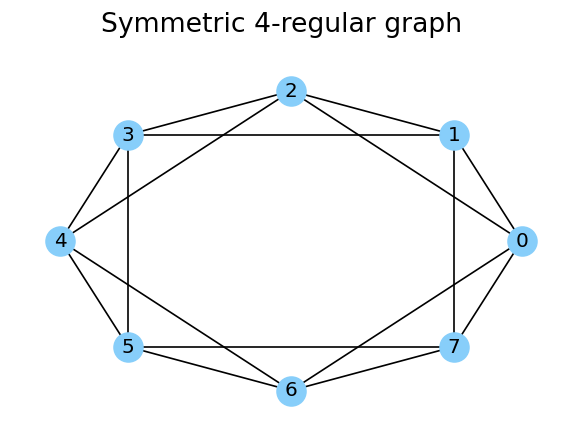

In [9]:
# Creating a k-regular example of graph with k = 4

n_nodes = 8
G = nx.cycle_graph(n_nodes)
create_k_regular_G(G,4,8)

pos = nx.circular_layout(G)
create_plot(G,1,'Symmetric 4-regular graph',pos)

Let $\beta = 0.3 $  be the probability that the infection is spread from an infected individual to a susceptible one (given that they are connected by a link) during one time step, and $\rho = 0.7$ be the probability that an infected individual will recover during one time step. The epidemic is driven by the following transition probabilities:

$$ P(X_I(t+1)=1 | X_i(t) = S, \sum_{j \in \mathcal{V}} W_{ij}\delta^I_{X_j(t)} = m ) = 1 - (1 - \beta)^m $$

$$ P(X_I(t+1)=R |X_i(t) = I) = p $$


where $ \sum_{j \in \mathcal{V}} W_{ij}\delta^I_{X_j(t)}$ is the number of infected neighbors for node i

Simulate the epidemic for $15$ weeks.The initial configuration is with $10$ infected nodes selected at random.
Do this $N = 100$ times and plot the following:

- The average number of newly infected individuals each week. 
- The average total number of susceptible, infected, and recovered individuals at each week.

***Solution***

In [4]:
state = {0:'S', 1:'I', 2:'R', 3:'V'}

In [179]:
n_nodes = 500
n_steps = 15
G = nx.cycle_graph(n_nodes)
create_k_regular_G(G,4,500)
pos = nx.circular_layout(G)
beta = 0.3
rho = 0.7
n_infected = 10

# Average of the simulation's results
new_infected_avg,_,susceptible_avg,infected_avg,recovered_avg,_ = SIR_avg_plotting(100,SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho))

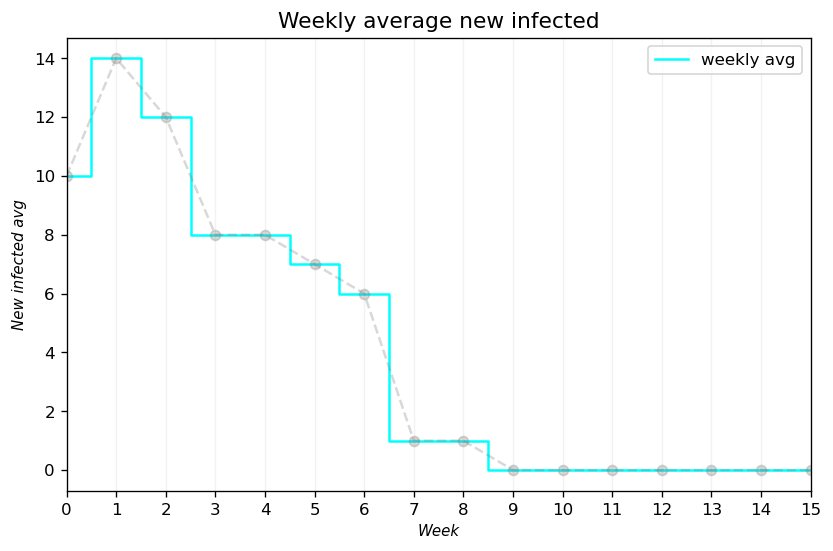

In [180]:
single_plot(x = np.arange(n_steps + 1), y=new_infected_avg, title="Weekly average new infected", x_label="Week", y_label="New infected avg", color="cyan",n = 2)

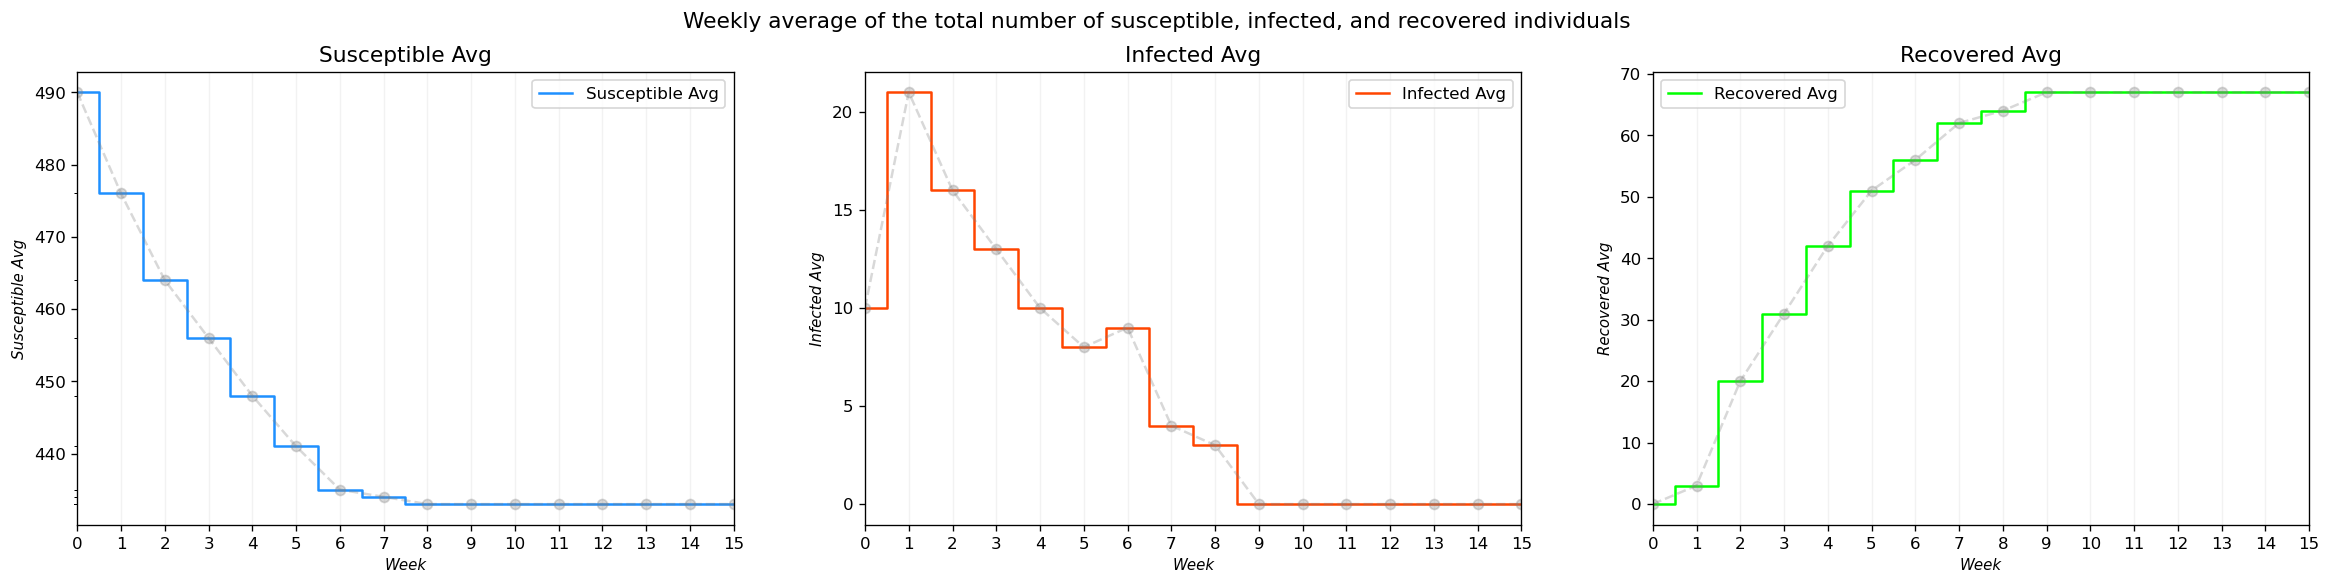

In [181]:
triple_plot(n_steps+1,susceptible_avg,infected_avg,recovered_avg,'Weekly average of the total number of susceptible, infected, and recovered individuals',n=3)

## Exercise 1.1.2
Generate a random graph according to the preferential attachment model, with average degree close to k.

The average degree of the random graph with 8+1  node at the beginning is 8.0


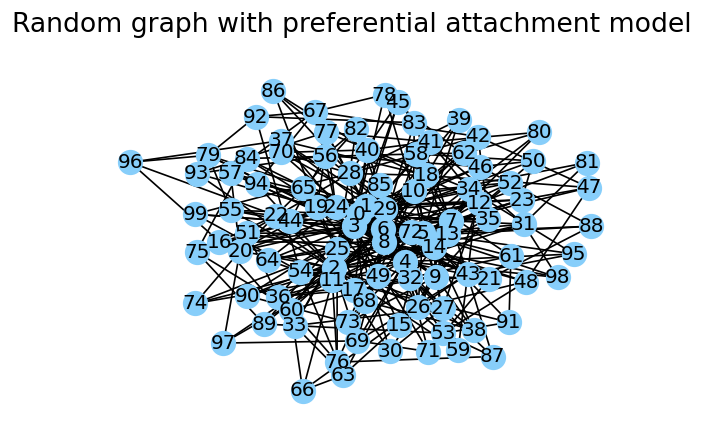

In [54]:
k = 8
G = nx.complete_graph(k+1)
n_nodes_tot = 100
avg_degree = create_random_graph(G,k,n_nodes_tot)
print(f'The average degree of the random graph with {k}+1  node at the beginning is {avg_degree}')
create_plot(G,4,'Random graph with preferential attachment model',nx.spring_layout(G), node_size = 200)

## Exercise 1.2 
Generate a preferential attachment random graph $G = (\mathcal{V,E})$, with $|\mathcal{V}| = 500$ nodes. 
The average degree should be $k = 6$. Let $\beta = 0.3$ and $\rho = 0.7$. With one week being one unit of time, simulate the epidemic for $15$ weeks. The initial configuration has 10 infected nodes. 

Do this N = 100 times and plot the following:
- The average number of newly infected individuals each week. In other words, you should plot how many individuals become infected each week.
- The average total number of susceptible, infected, and recovered individuals at each week. In other words, you should plot how many individuals in total that are susceptible/infected/recovered at each week.

***Solution***

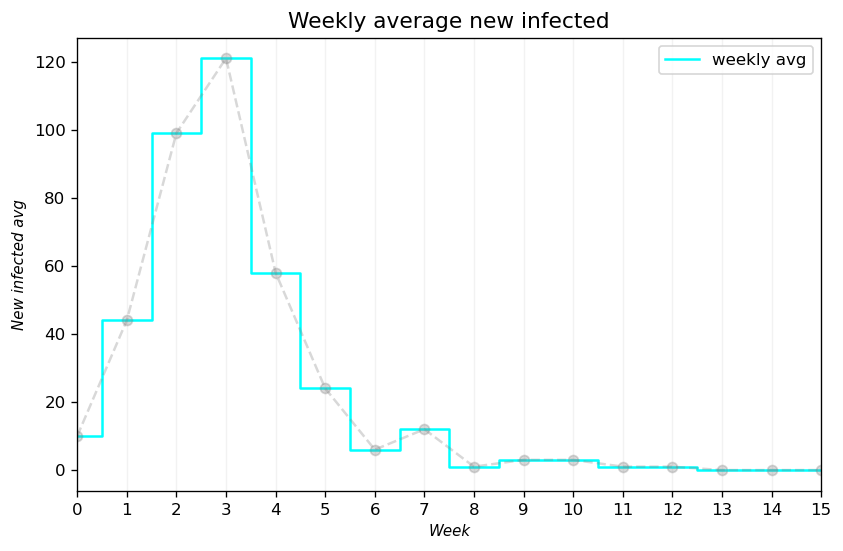

In [183]:
k = 6
G = nx.complete_graph(k+1)
n_nodes = 500
beta = 0.3
rho = 0.7
n_steps = 15
n_infected = 10

create_random_graph(G,k,n_nodes)

# Average of the simulation's results
new_infected_avg,_,susceptible_avg,infected_avg,recovered_avg,_ = SIR_avg_plotting(100,SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho))
single_plot(x = np.arange(n_steps + 1), y=new_infected_avg, title="Weekly average new infected", x_label="Week", y_label="New infected avg", color="cyan",n = 5)

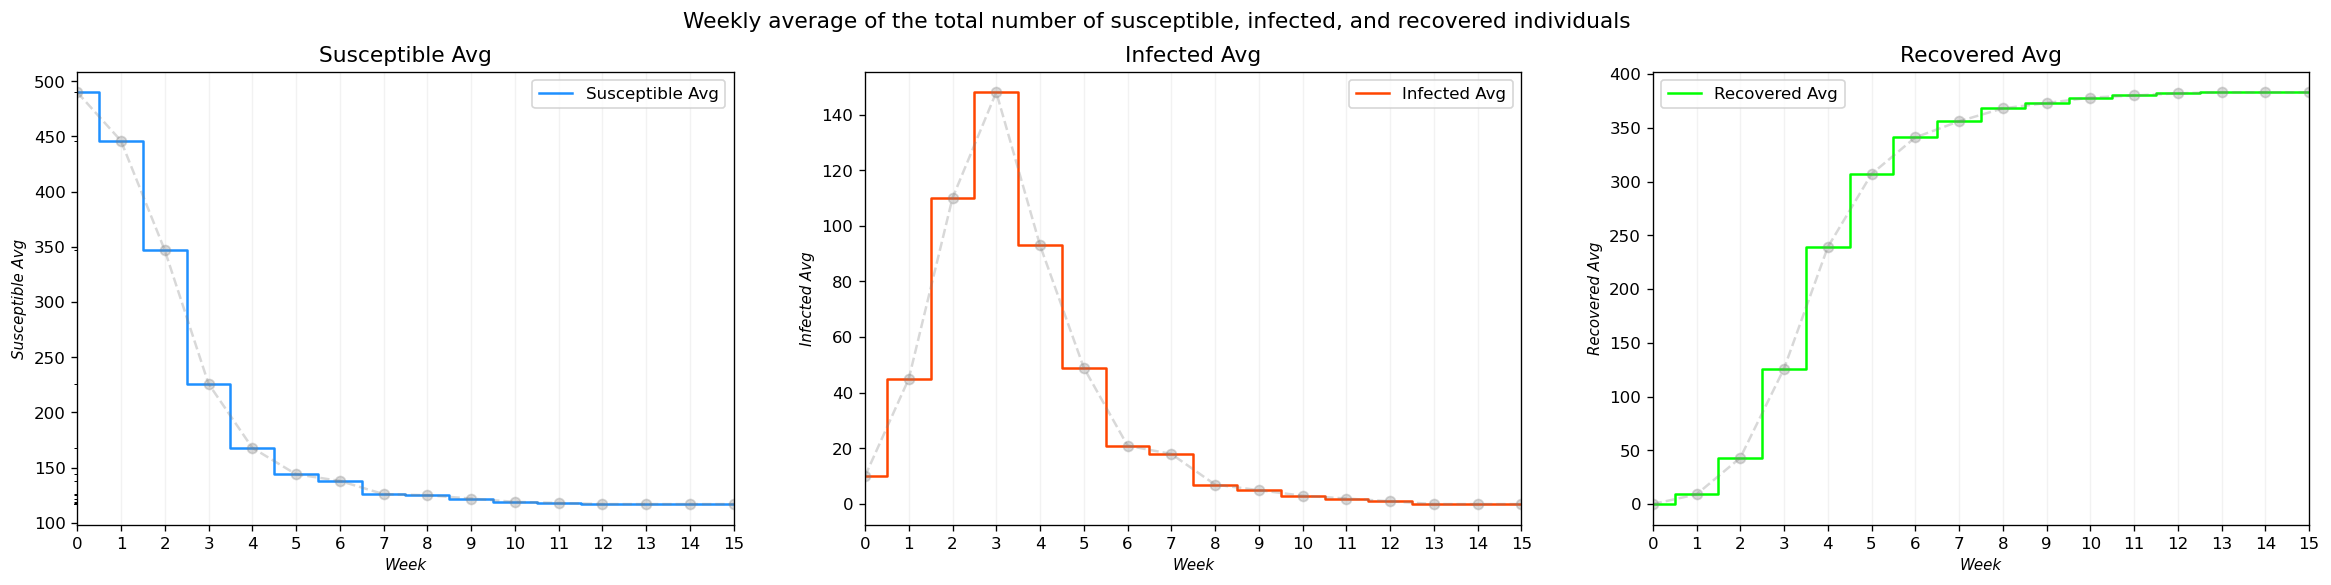

In [185]:
triple_plot(n_steps+1,susceptible_avg,infected_avg,recovered_avg,'Weekly average of the total number of susceptible, infected, and recovered individuals',n=6)

## Exercise 1.3

Simulate the disease propagation for 15 weeks, but with the distribution of vaccination to the population. This should be done such that the total fraction of population that has received vaccination by each week is according to:

$$ Vacc(t) = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60] $$

Generate a random graph $G = (\mathcal{V,E})$, with $|\mathcal{V}| = 500$ nodes.  The average degree should be $k = 6$. Let $\beta = 0.3$ and $\rho = 0.7$. With one week being one unit of time, simulate the epidemic for $15$ weeks, using the vaccination scheme *Vacc(t)* above. The initial configuration has $10$ infected nodes.  Do this $N = 100$ times and plot the following:
- The average number of newly infected and newly vaccinated individuals each week.
- The average total number of susceptible, infected, recovered and vaccinated individuals at each week.


***Solution***

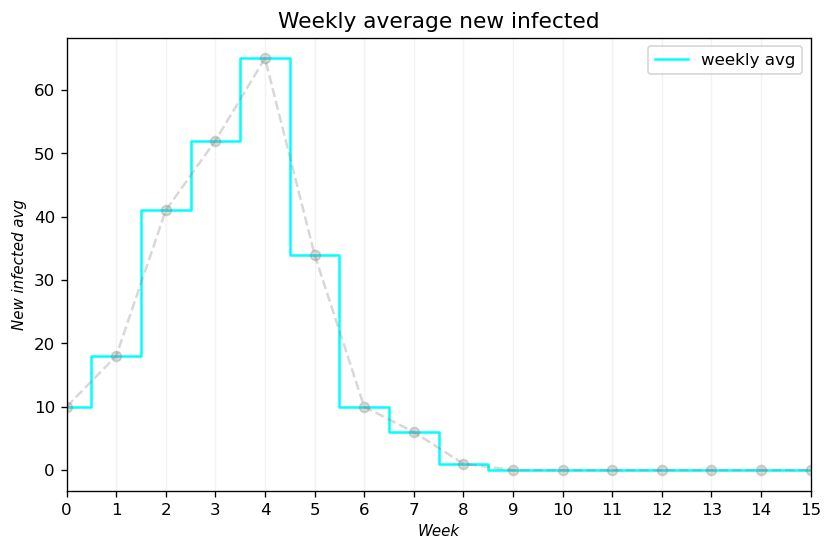

In [188]:
vacc = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
vacc_increments = create_increments_from_array(vacc)
k = 6
G = nx.complete_graph(k+1)
n_nodes = 500
beta = 0.3
rho = 0.7
n_steps = 15
n_infected = 10

create_random_graph(G,k,n_nodes)
new_infected_avg,new_vaccinated_avg,susceptible_avg,infected_avg,recovered_avg,vaccinated_avg =SIR_avg_plotting( 100, SIR_epidemic(G,n_nodes,n_infected,n_steps, beta, rho, use_vaccine = 1, vacc_increments = vacc_increments))
single_plot(x = np.arange(n_steps + 1), y=new_infected_avg, title="Weekly average new infected", x_label="Week", y_label="New infected avg", color="cyan",n = 7)

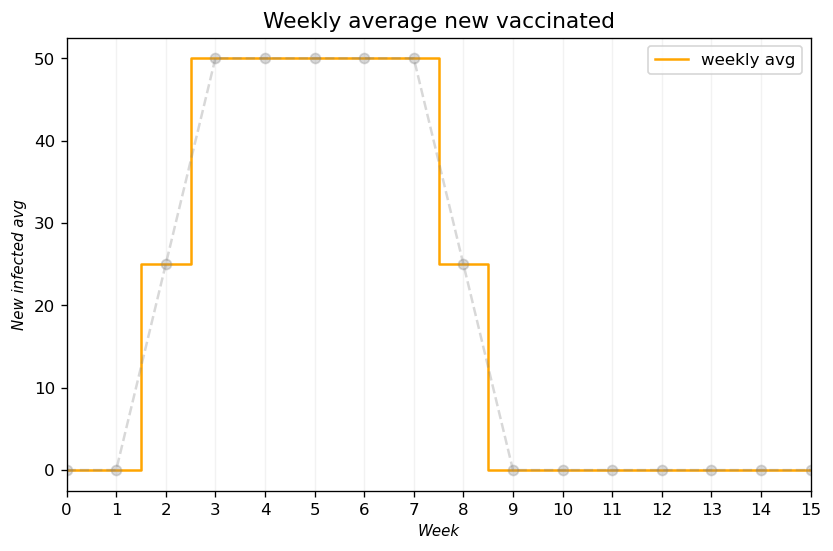

In [190]:
single_plot(x = np.arange(n_steps+1), y=new_vaccinated_avg, title="Weekly average new vaccinated", x_label="Week", y_label="New infected avg", color="orange",n = 8)

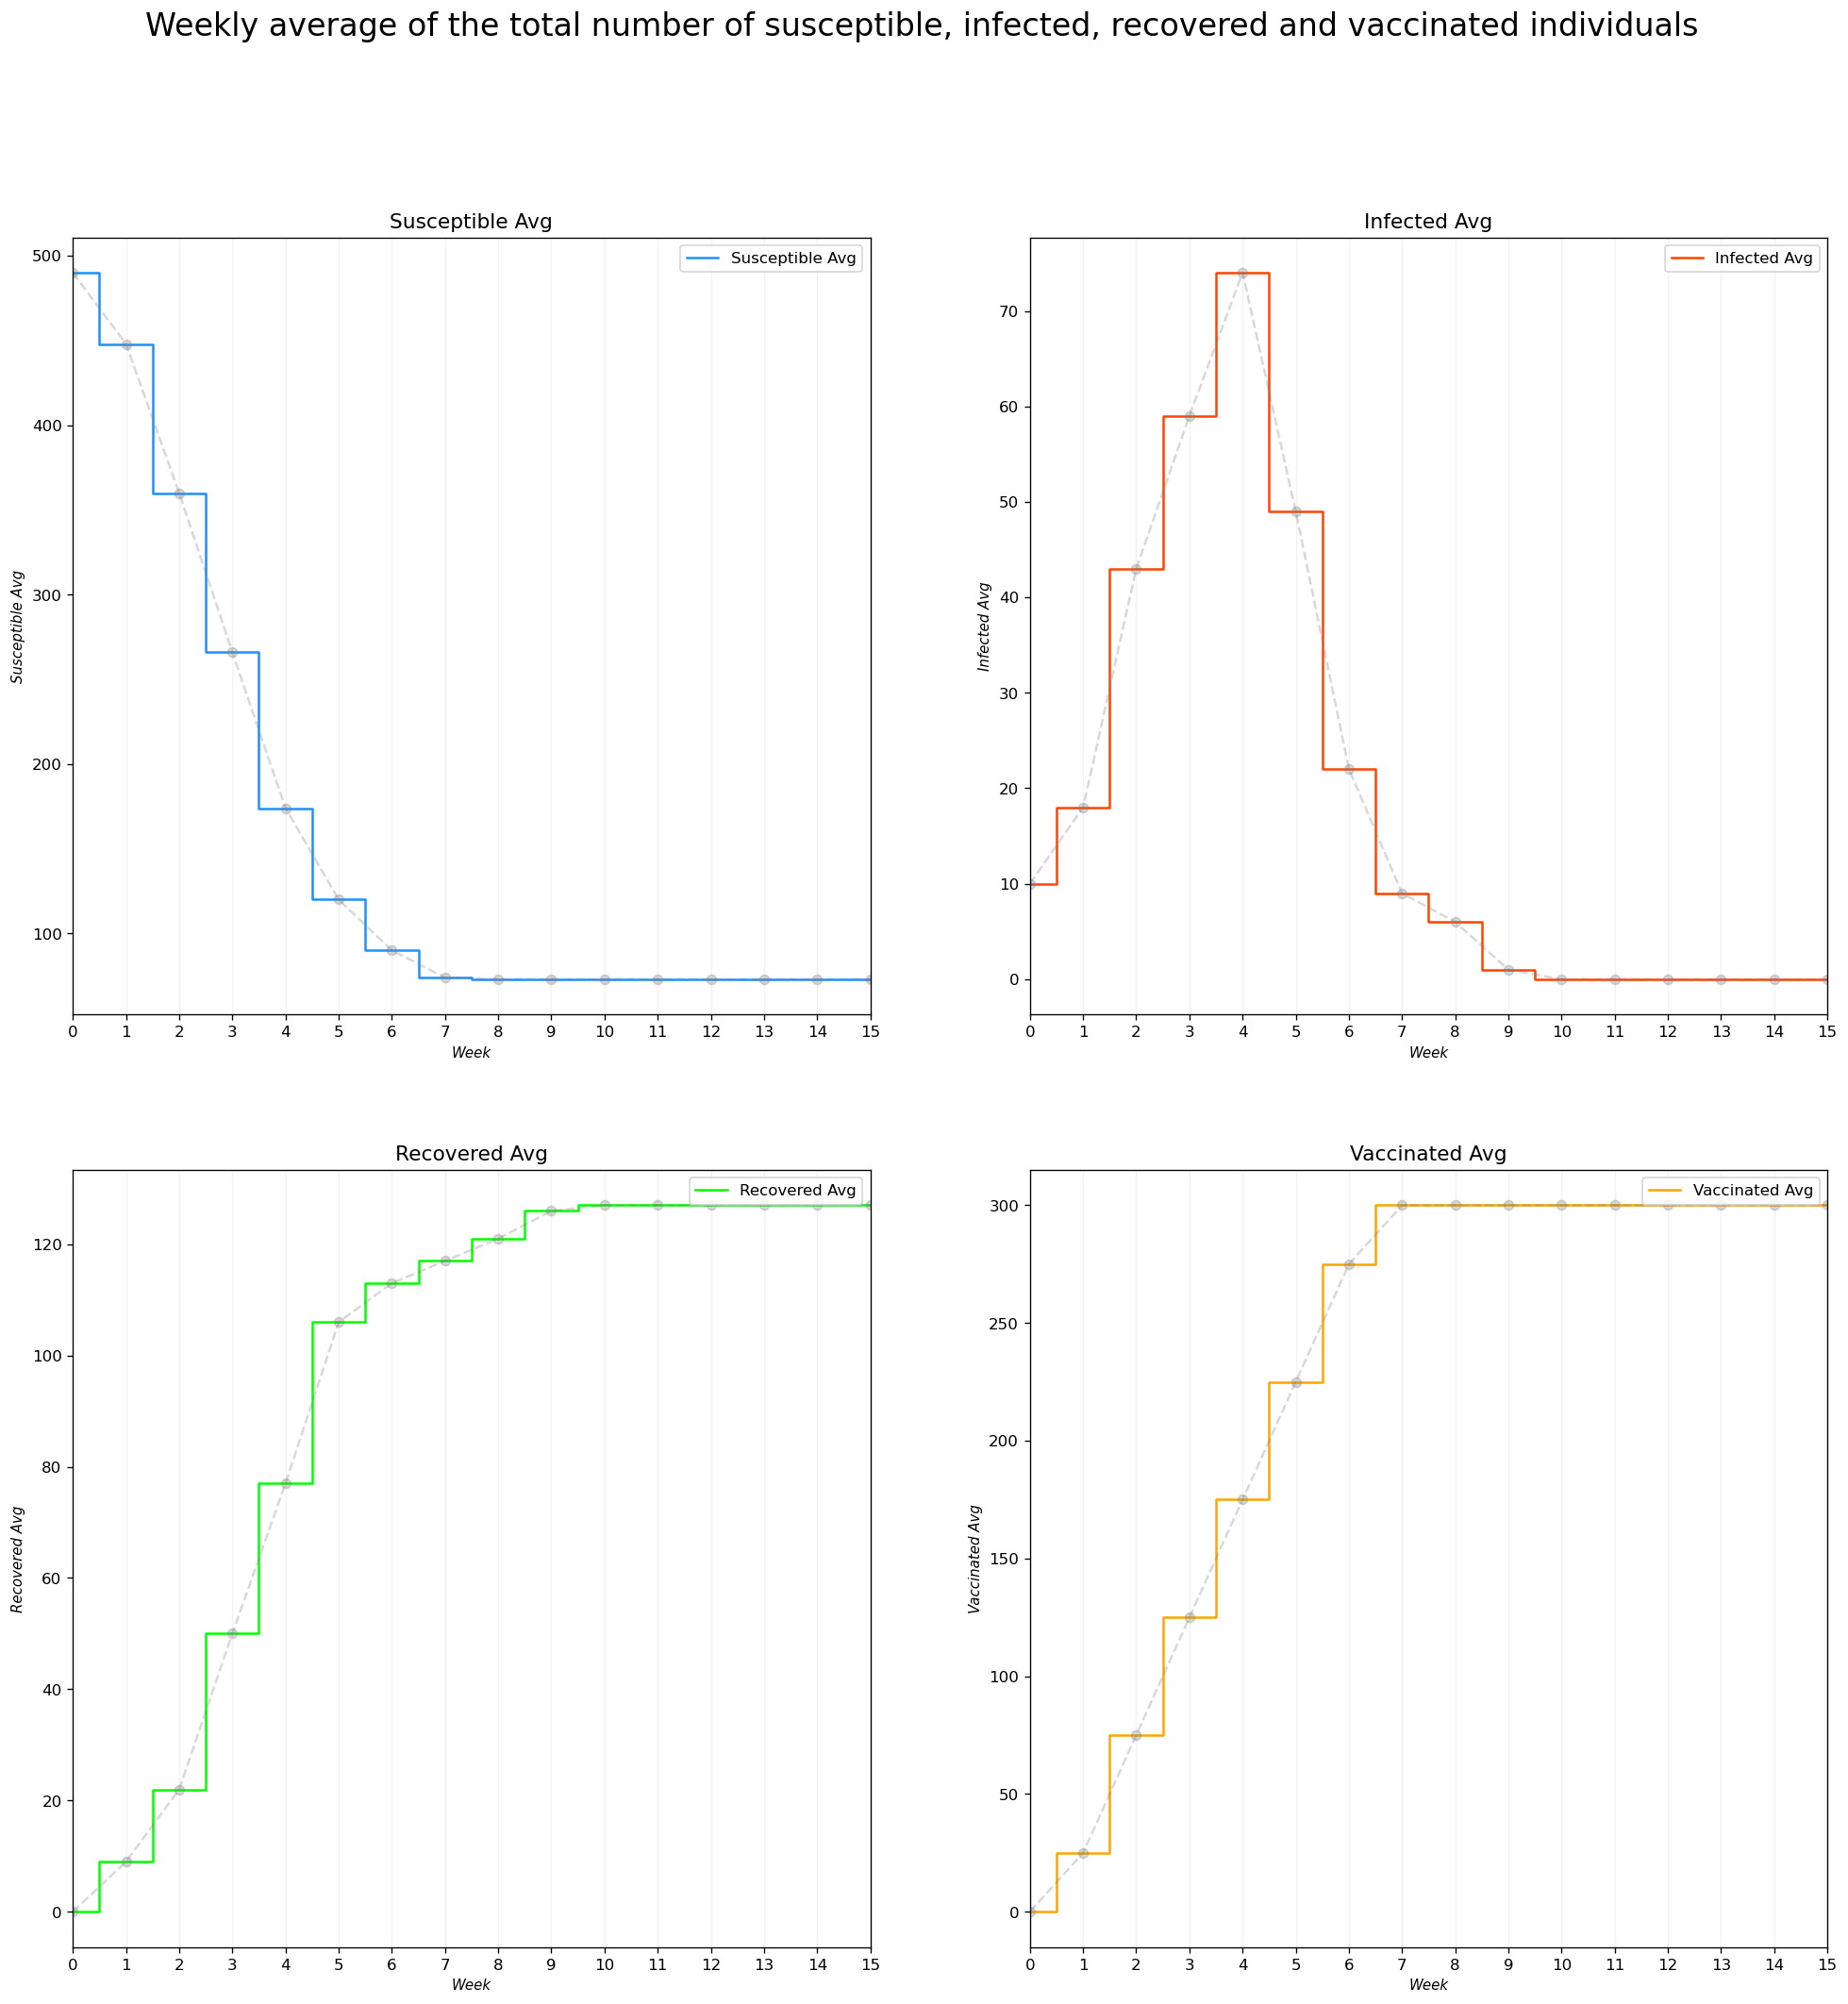

In [194]:
quadruple_plot(9,16, susceptible_avg,infected_avg,recovered_avg,vaccinated_avg)

## Exercise 1.4

Simulate the pandemic for 15 weeks. During these weeks, the fraction of population that had received vaccination was:

$$Vacc(t) = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] $$

The population is $ n = | \mathcal{V}| = 934$. The number of newly infected individuals each week was:

$$ I_0(t) = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0] $$

Implement an algorithm that will do a gradient-based search over the parameter space of $k, \beta,$
and $\rho$ in order to find the set of parameters that best matches the real pandemic.

Once you have found the best estimate, report what parameters you got. You should also show the following plots:

- The average number of newly infected individuals each week according to the model (with your best parameters) compared to the true value of newly infected individuals each week.
- The total number of susceptible, infected, recovered and vaccinated individuals at each week according to the model.



***Solution***

### First algorithm
The firstalgorithm keeps $\Delta k ,\Delta \beta,$ and $\Delta \rho$ fixed and changes only the centre of the interval

In [119]:
print('The first algorithm')
min_rmse1, epidemic1=simulation_H1N1()
#compare_plot(13,epidemic1[0])

The first algorithm
END with RMSE = 8.370583412562512
at epoch: 6
Best set of parameter: k 8 beta 0.19999999999999998 rho 0.6


The second algorithm update also $\Delta k ,\Delta \beta,$ and $\Delta \rho$ only if the ***RMSE*** goes down to $4$

In [93]:
print("The second algorithm")
min_rmse2, epidemic2=simulation_H1N1(fixed=False)
#compare_plot(14,epidemic2[0])

The second algorithm
END with RMSE = 7.183313998427188
at epoch: 6
Best set of parameter: k 8 beta 0.09999999999999998 rho 0.4


The third simulation update also $\Delta k ,\Delta \beta,$ and $\Delta \rho$ only if the epoch is odd

In [212]:
print("The third algorithm")
min_rmse3, epidemic3=simulation_H1N1(pairchanges=False)
#compare_plot(15,epidemic3[0])

The third algorithm
END with RMSE = 6.413527370592047
at epoch: 5
Best set of parameter: k 9 beta 0.09999999999999998 rho 0.5


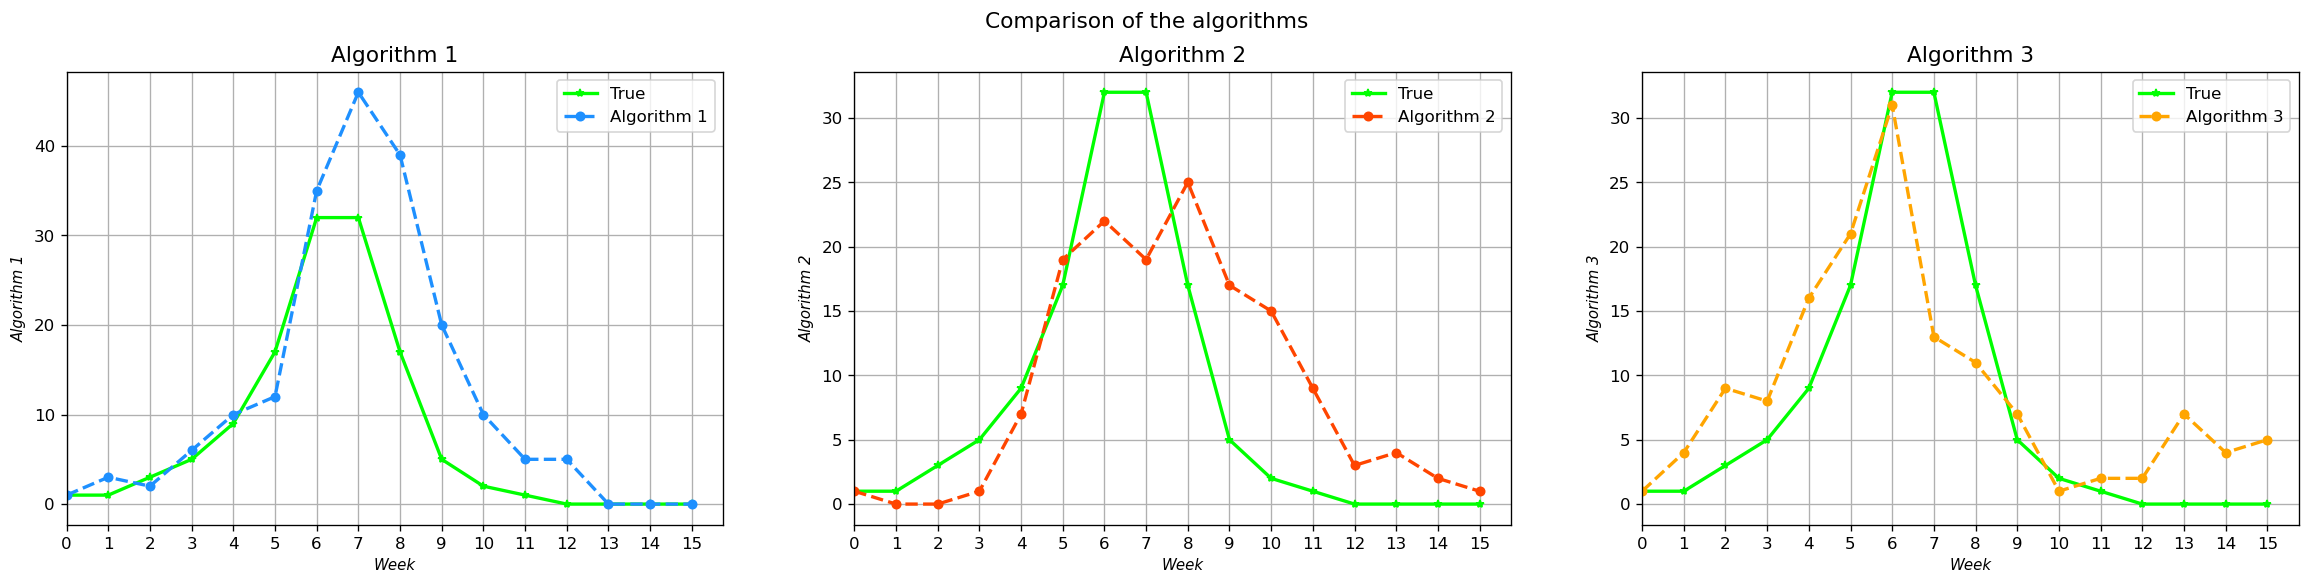

In [215]:
compare_plot_triple(13,epidemic1[0],epidemic2[0],epidemic3[0])

The three algorithm are almost the same, the one which gives a better rmse is the third. The weekly average of the total number of susceptible, infected, recovered and vaccinated individuals of the third simulation is here:

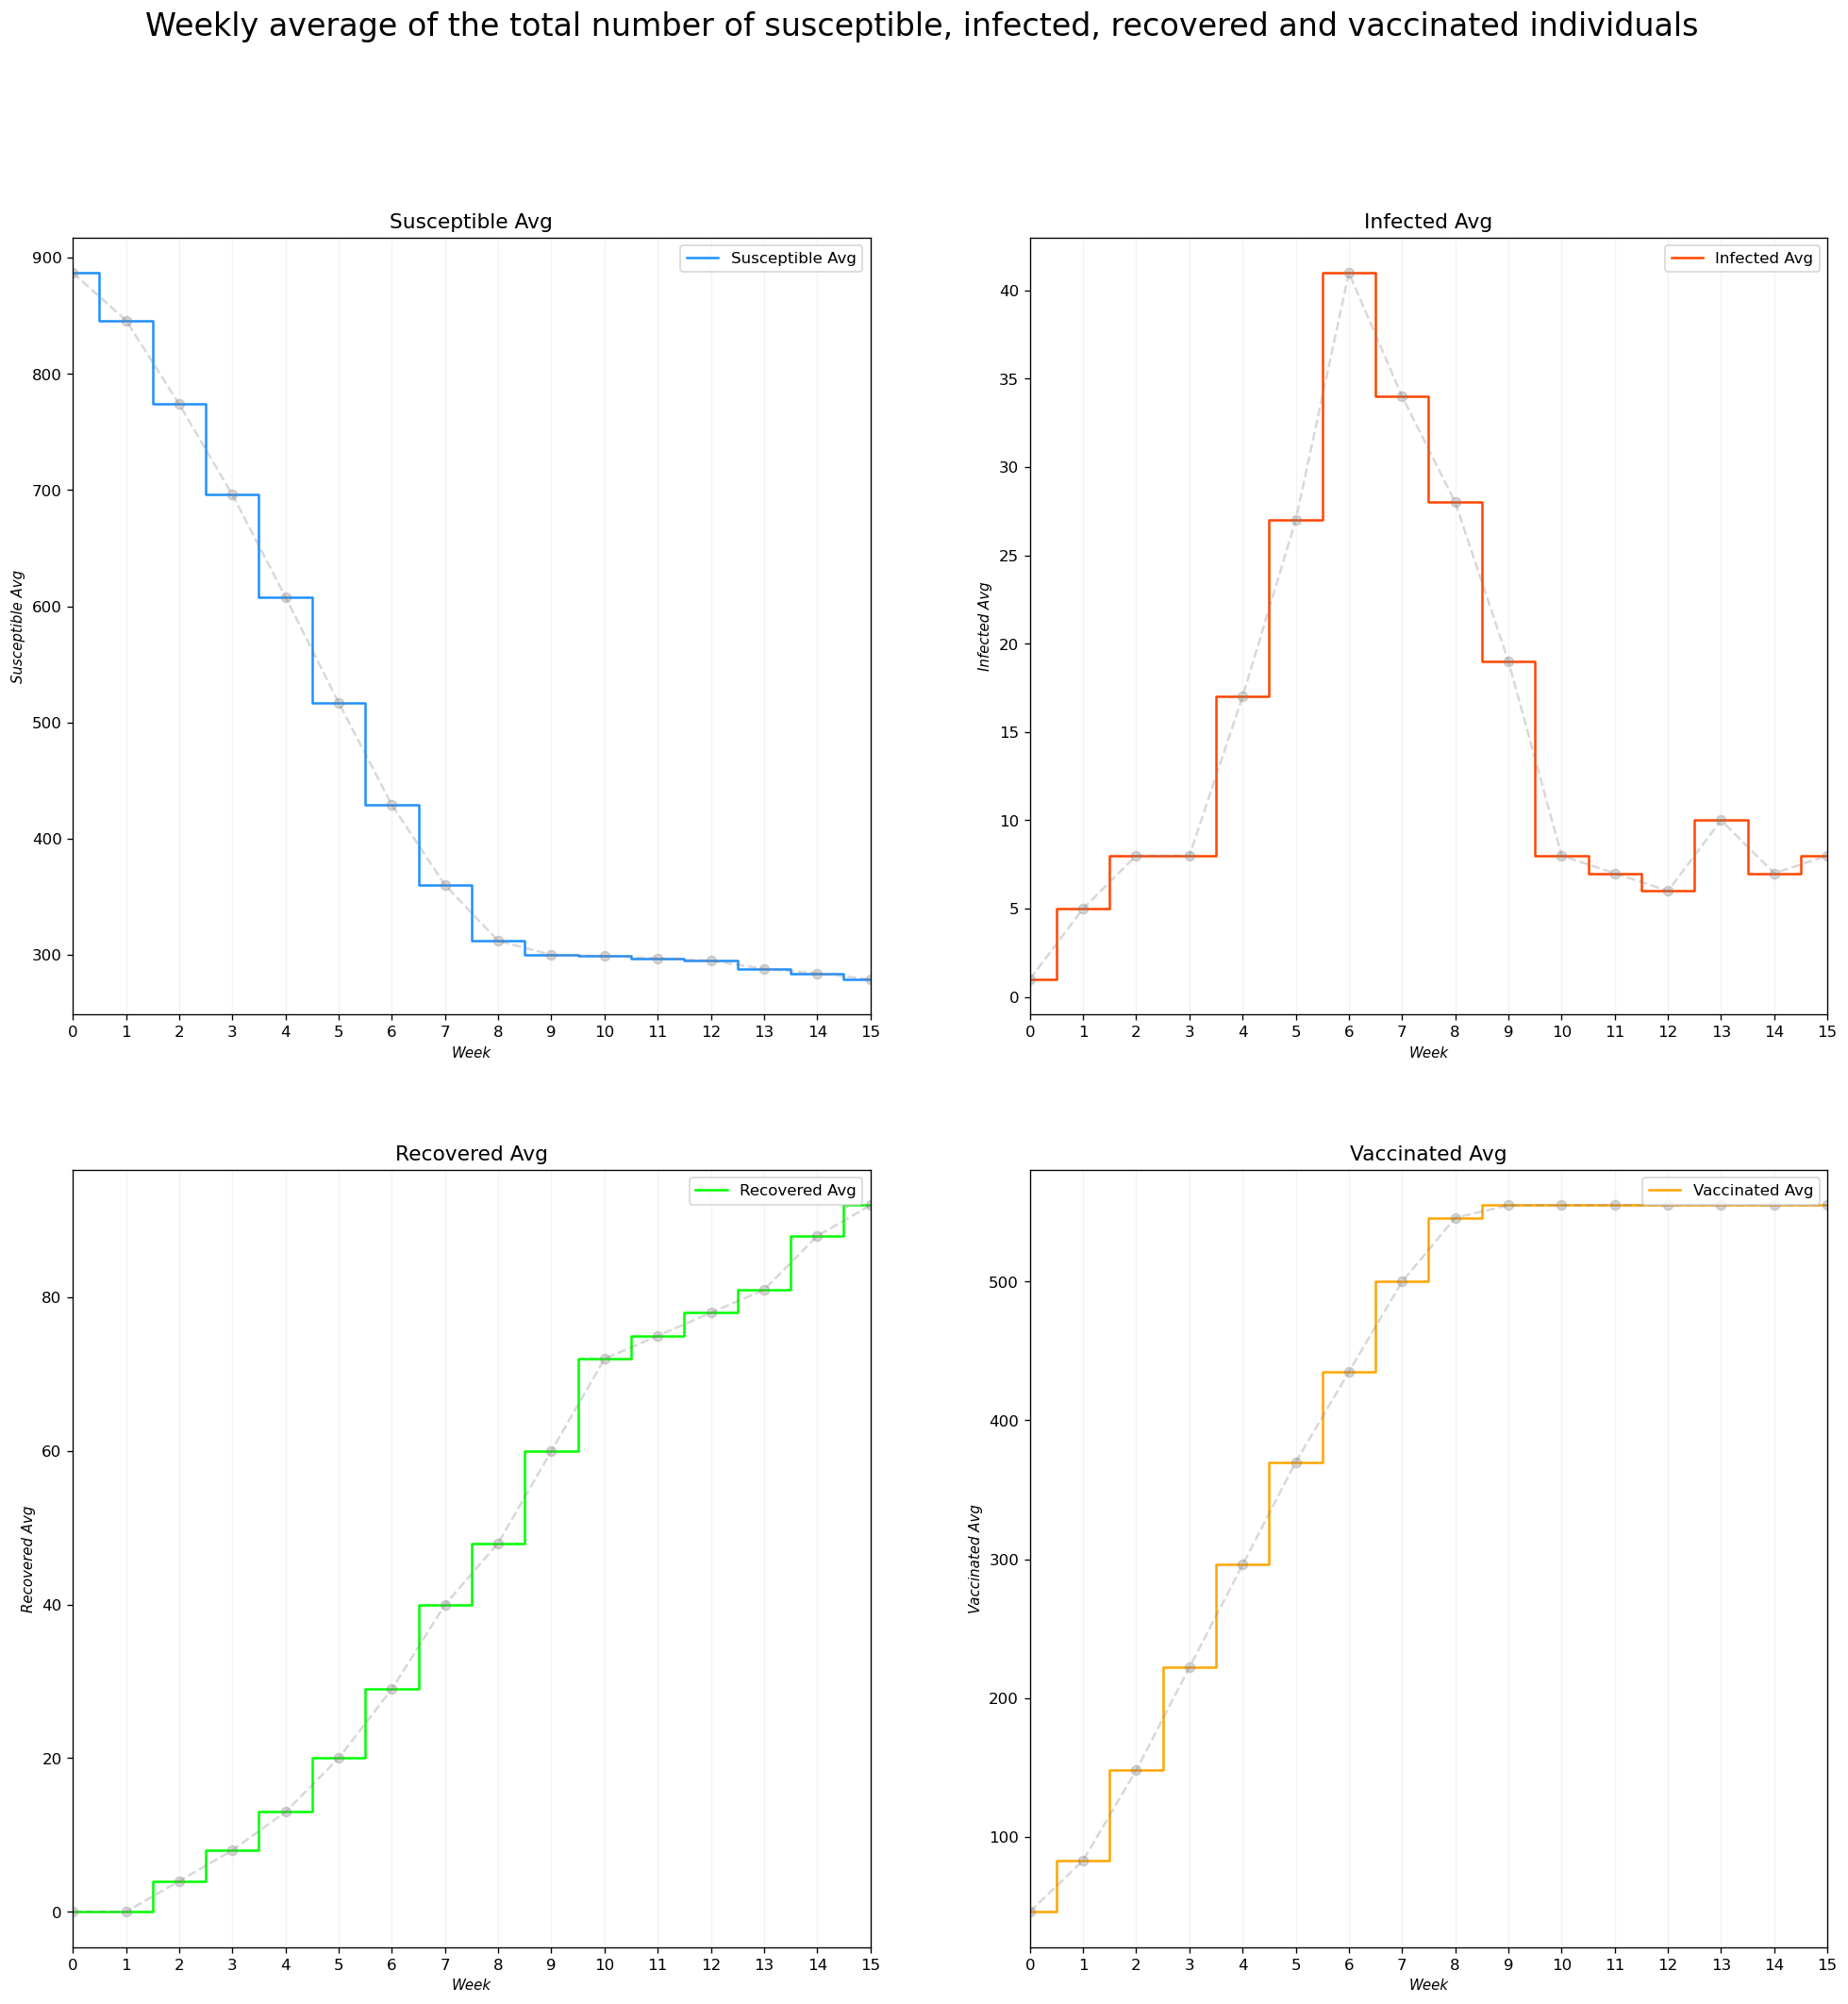

In [216]:
quadruple_plot(14,16, epidemic3[1],epidemic3[2],epidemic3[3],epidemic3[4])

## Exercise 1.5

Find a better random graph (i.e. one that does not use preferential attachment) to represent the network for the pandemic. Try to also find a better algorithm to estimate the parameters.

*Solution*

In a population, there is a huge number of connections between people, a friend of a friend could be related to many other people. In this sense, the graph that we need to represents in order to simulate a population must have really big connected components. It is quite impossible to find people that are not connected with any one and so the graph shouldn't contain isolated nodes. Also, if two people are friends of a third person, it is quite likely that they are friends too. 
The best model that represents these conditions is the ***small world graph***, infact it has:

- small diameter (sublinear in $n$)
- large clustering coefficient (i.e., large number of triangles in the graph): in terms of social networks, clustering coefficient in some sense describes "how many friends of a given node are friends to each other"

In the 1960’s, Stanley Milgram carried out an experiment that indicated that any two individuals in the United States were connected by a short sequence of acquaintances,i.e., the graph that better represents a population is connected with a small diameter.

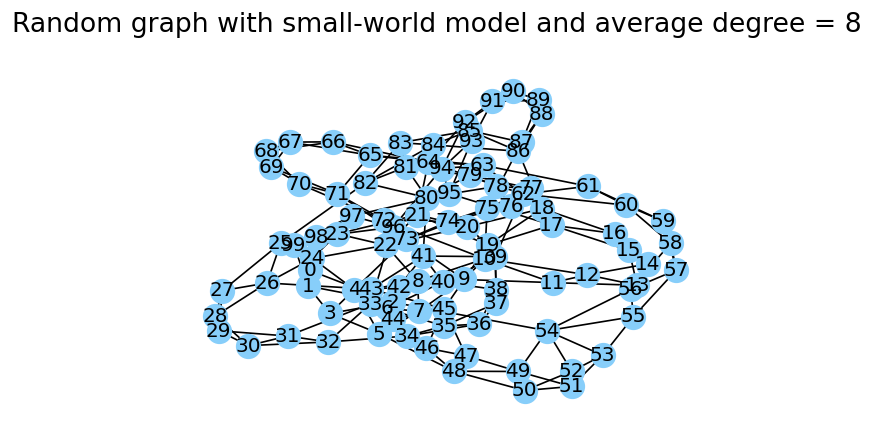

In [137]:
n_nodes = 100
G = nx.cycle_graph(n_nodes)
create_small_world_g(G,n_nodes = n_nodes)
create_plot(G,12,'Random graph with small-world model and average degree = 8',nx.spring_layout(G), node_size = 200)

The simulation of the algorithm of **Exercise 1.4*** using the random graph with small world model is:

END with RMSE = 5.310367218940701
at epoch: 8
Best set of parameter: k 12 beta 0.3 rho 0.9999999999999999


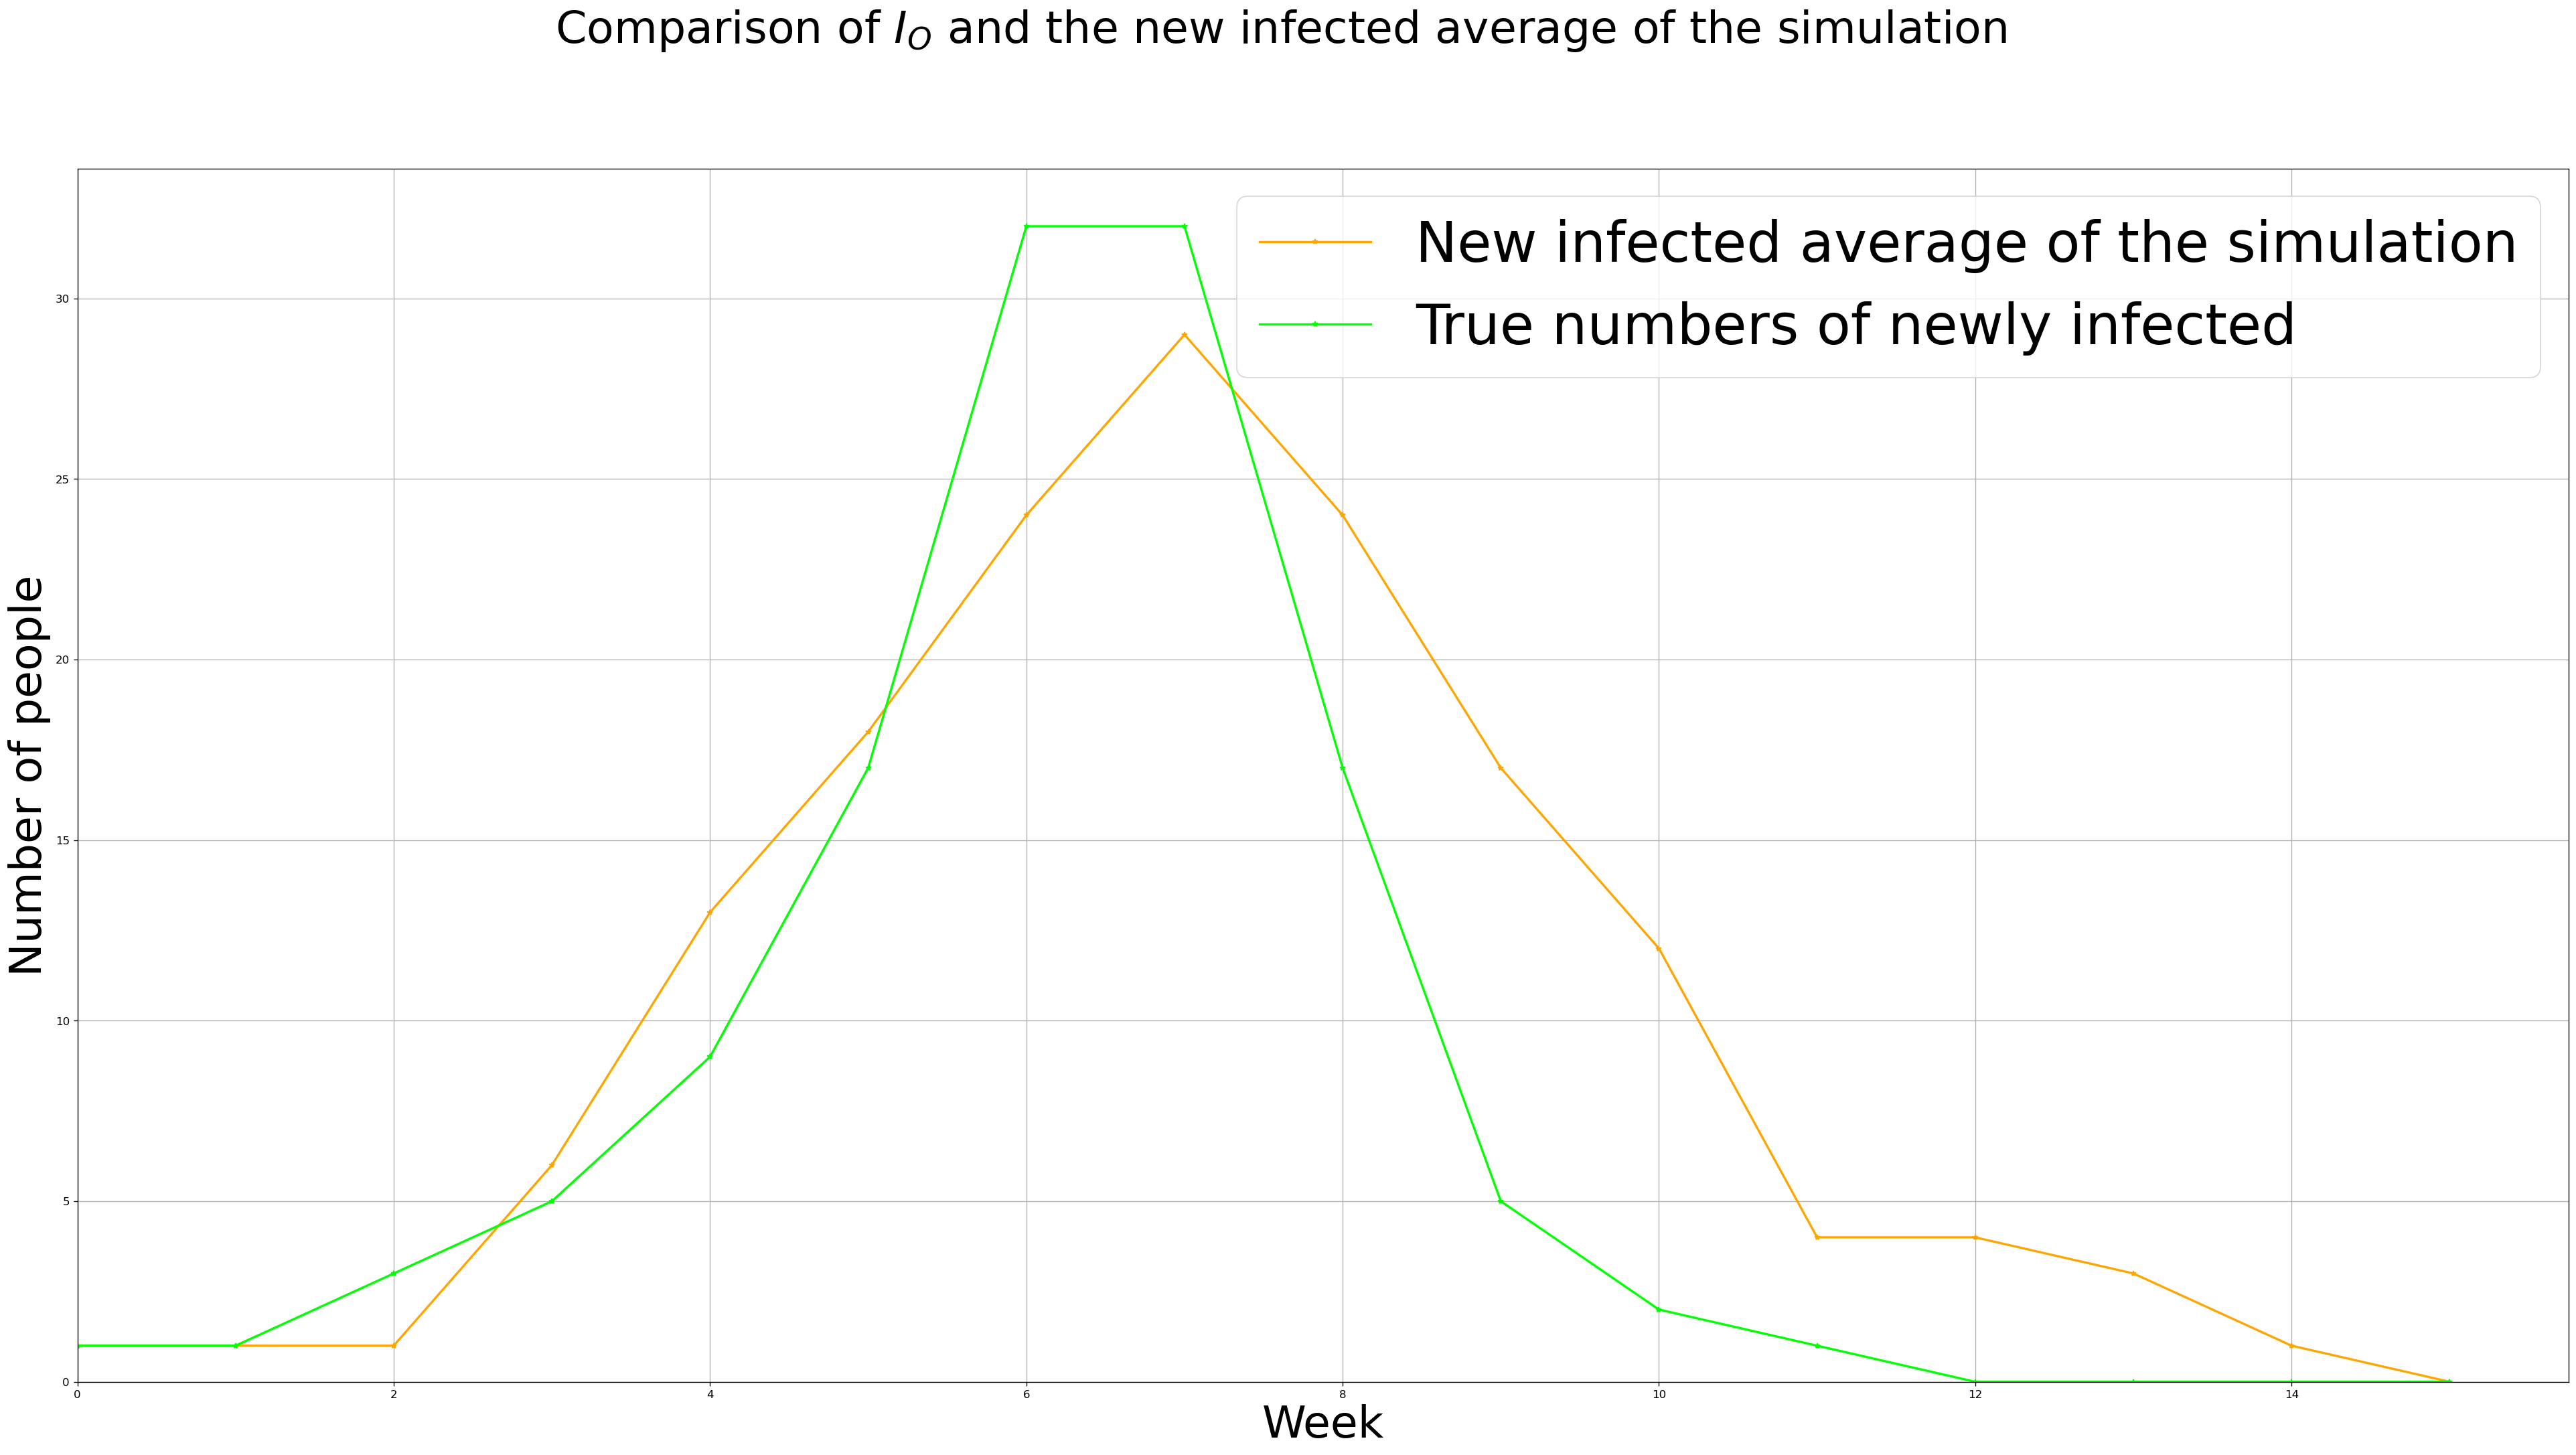

In [122]:
min_rmse, epidemic =simulation_H1N1(change_random_graph=True)
compare_plot(15,epidemic[0])

A logical other possible algorithm to find the best set of parameters is to generate randomly from the parameters-spaces, the three parameter, compare them to another set randomly chosen, and each time keeping saved the set of parameter which gives the best RMSE.

END with RMSE = 3.1937438845342623
Best set of parameter: k 0.8000000000000003 beta 0.27499999999999997 rho 9


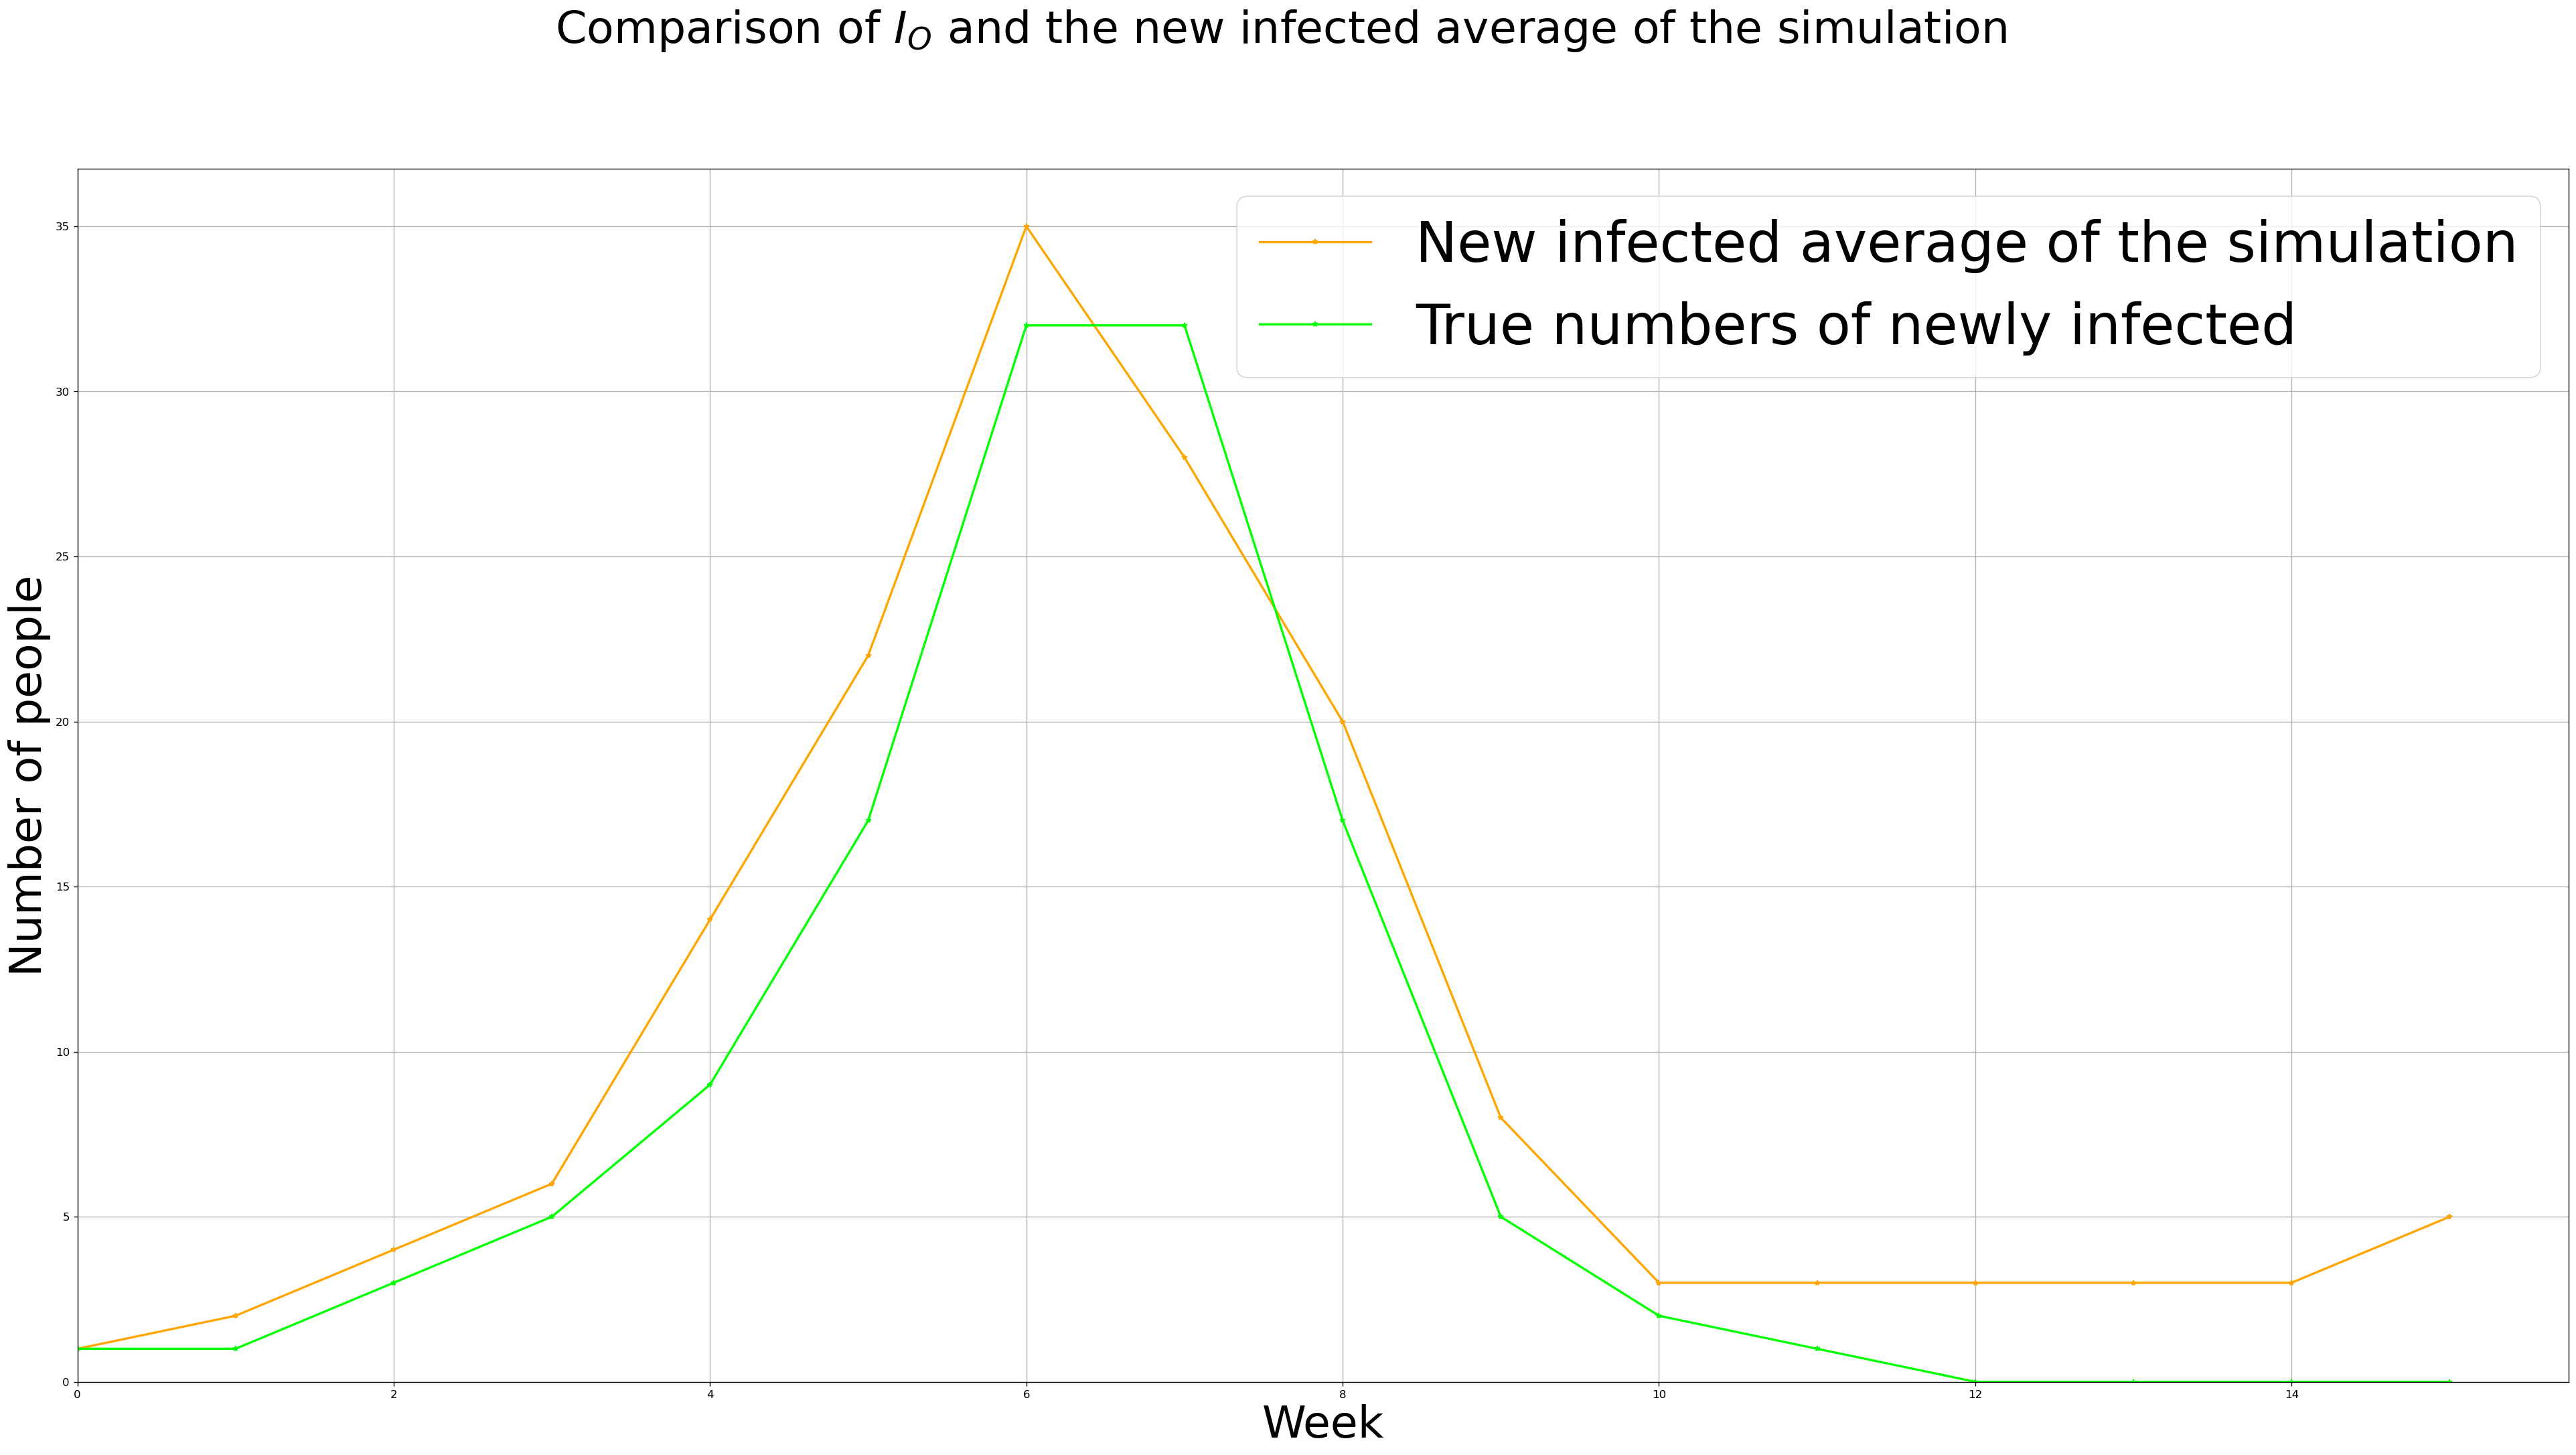

In [20]:
best_rmse, best_values, best_epidemics=random_choice_sim(temperature = 5 , alpha= 0.95, change_random_graph = True)
compare_plot(16,best_epidemics[0])

A more general algorithm that could be adapted for more simulation of an epidemic beside this one, is obtained using an easier version of ***simulated annealing*** technique: in the context of feature selection, simulated annealing finds the subset of features that gives the best predictive model performance amongst the many possible subset combinations. 

END with RMSE = 5.278888771954441
at epoch: 5
Best set of parameter: k 12 beta 0.24483069433695573 rho 0.8341613878793169


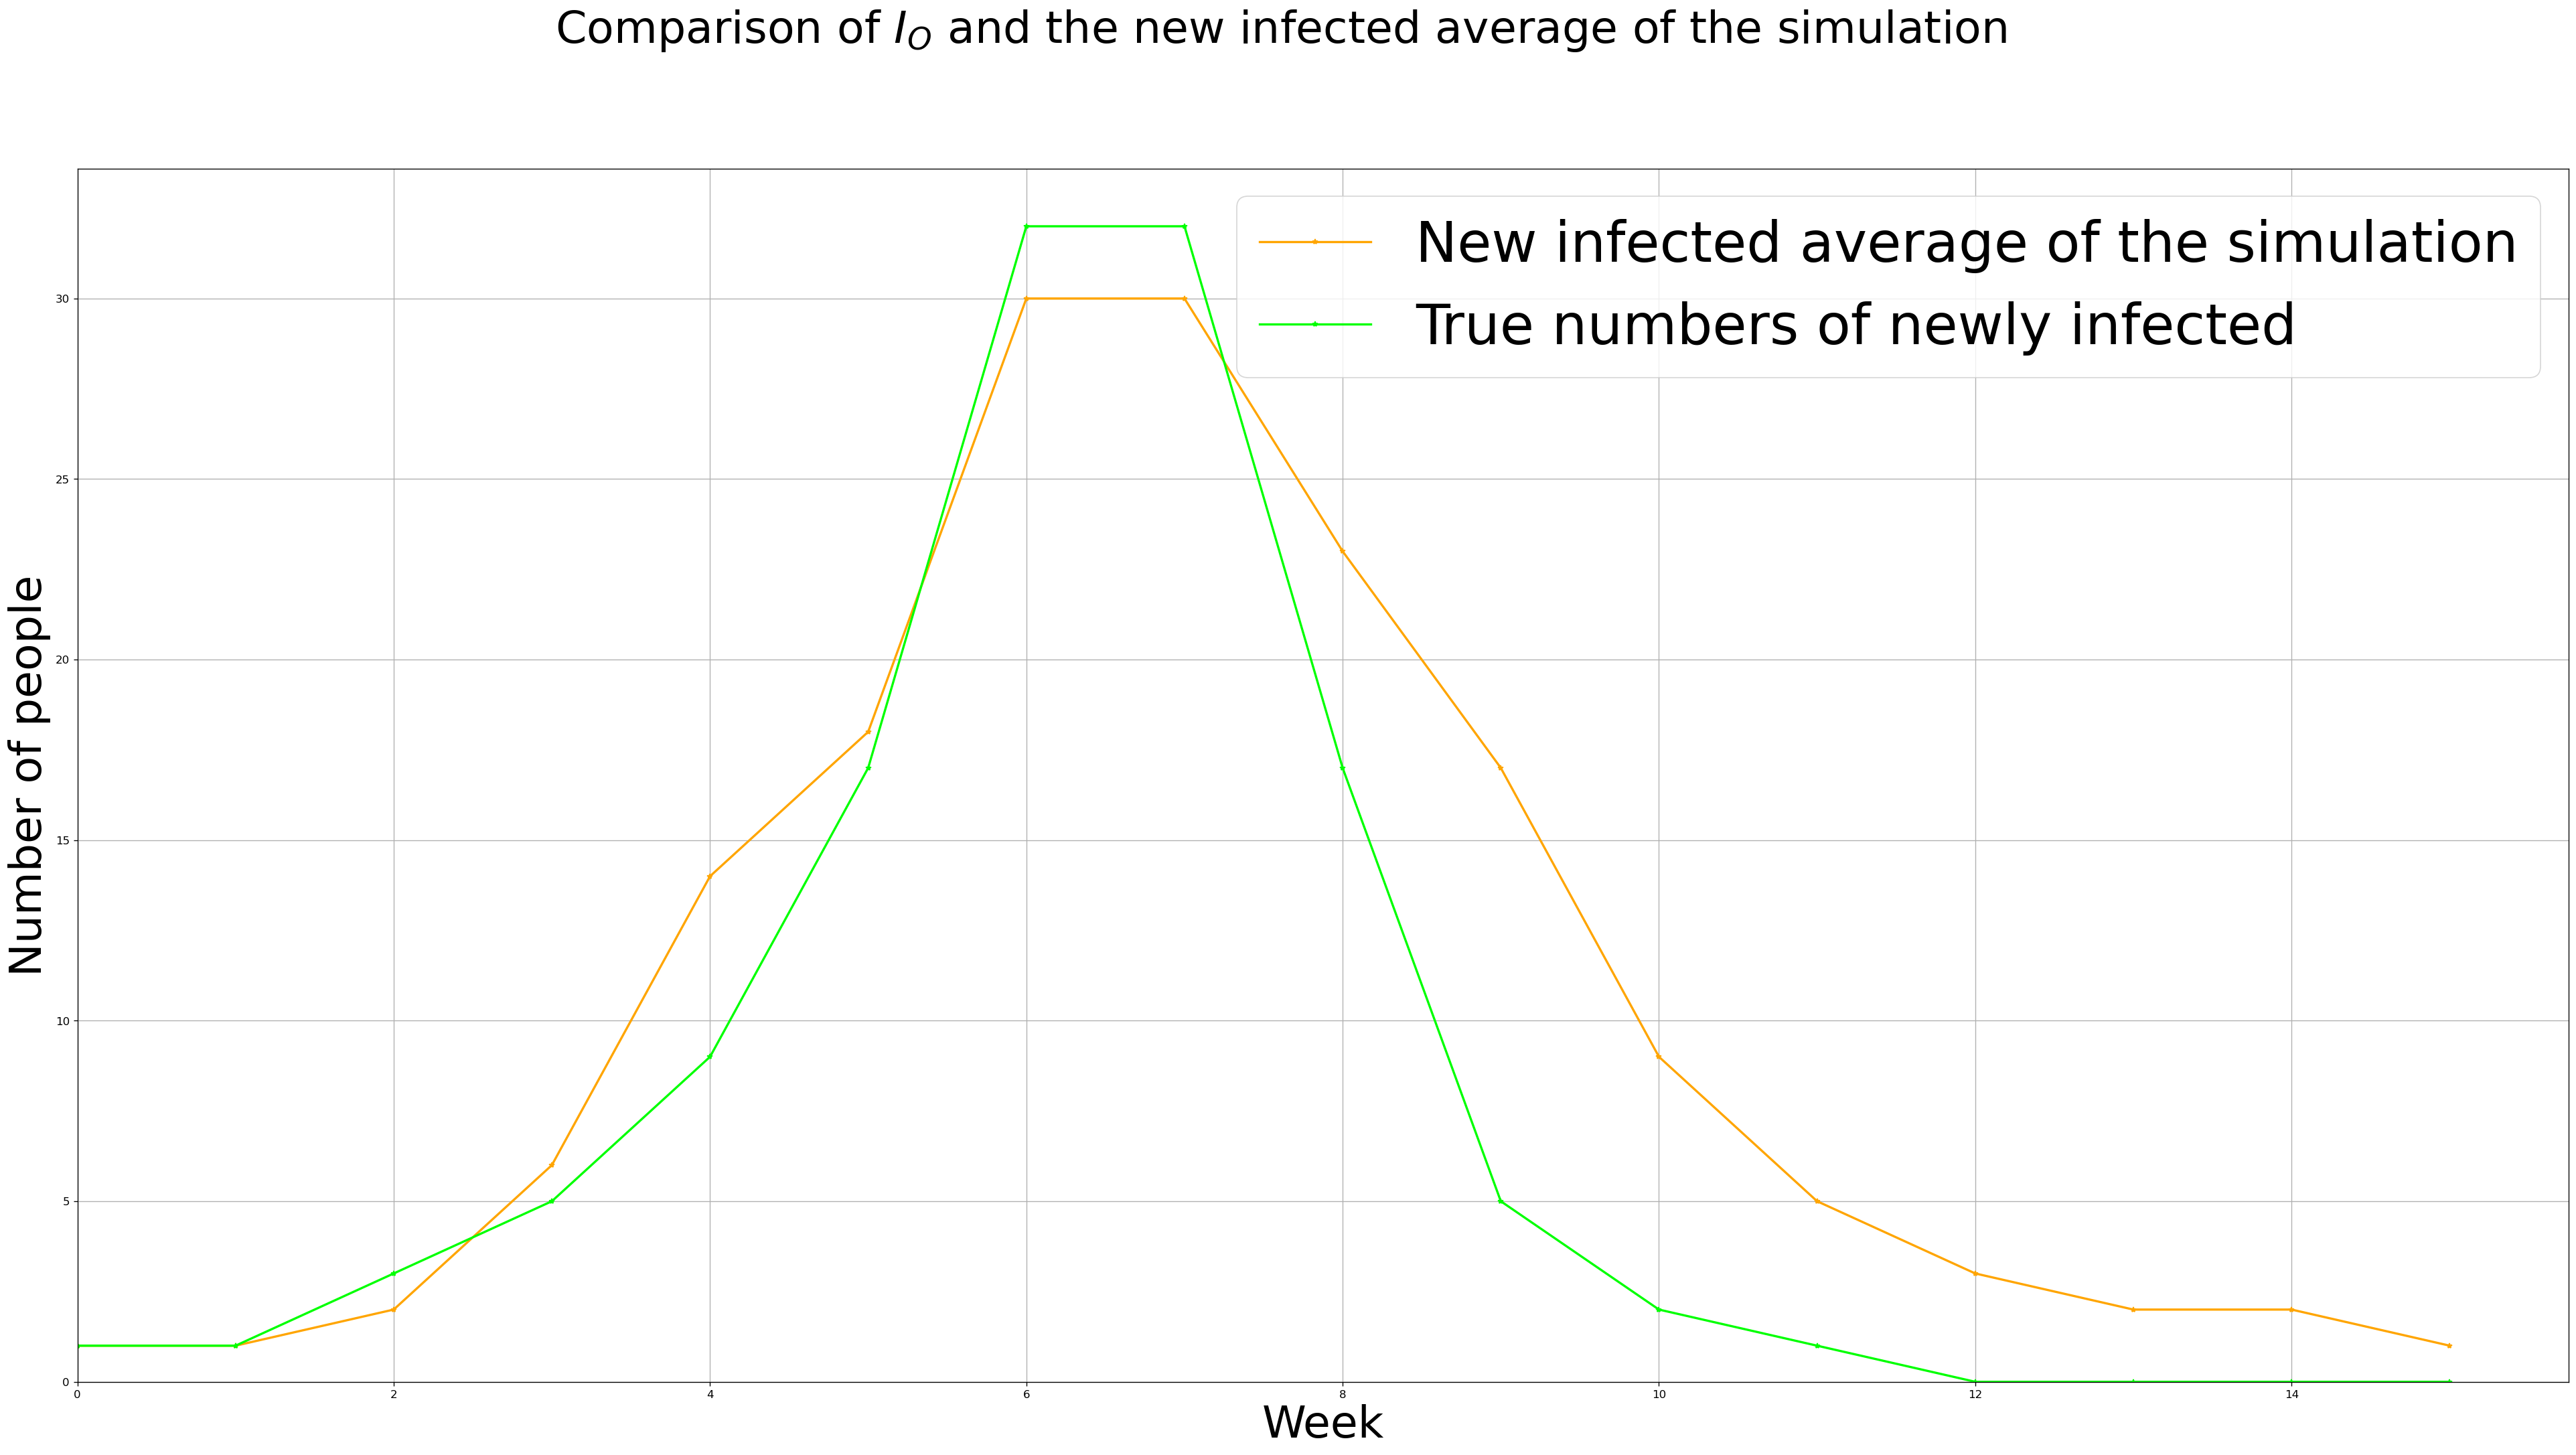

In [224]:
GLOBAL_BEST_RMSE, GLOBAL_BEST_VALUES, GLOBAL_BEST_epidemic=simulated_annealing()
compare_plot(17,GLOBAL_BEST_epidemic[0])

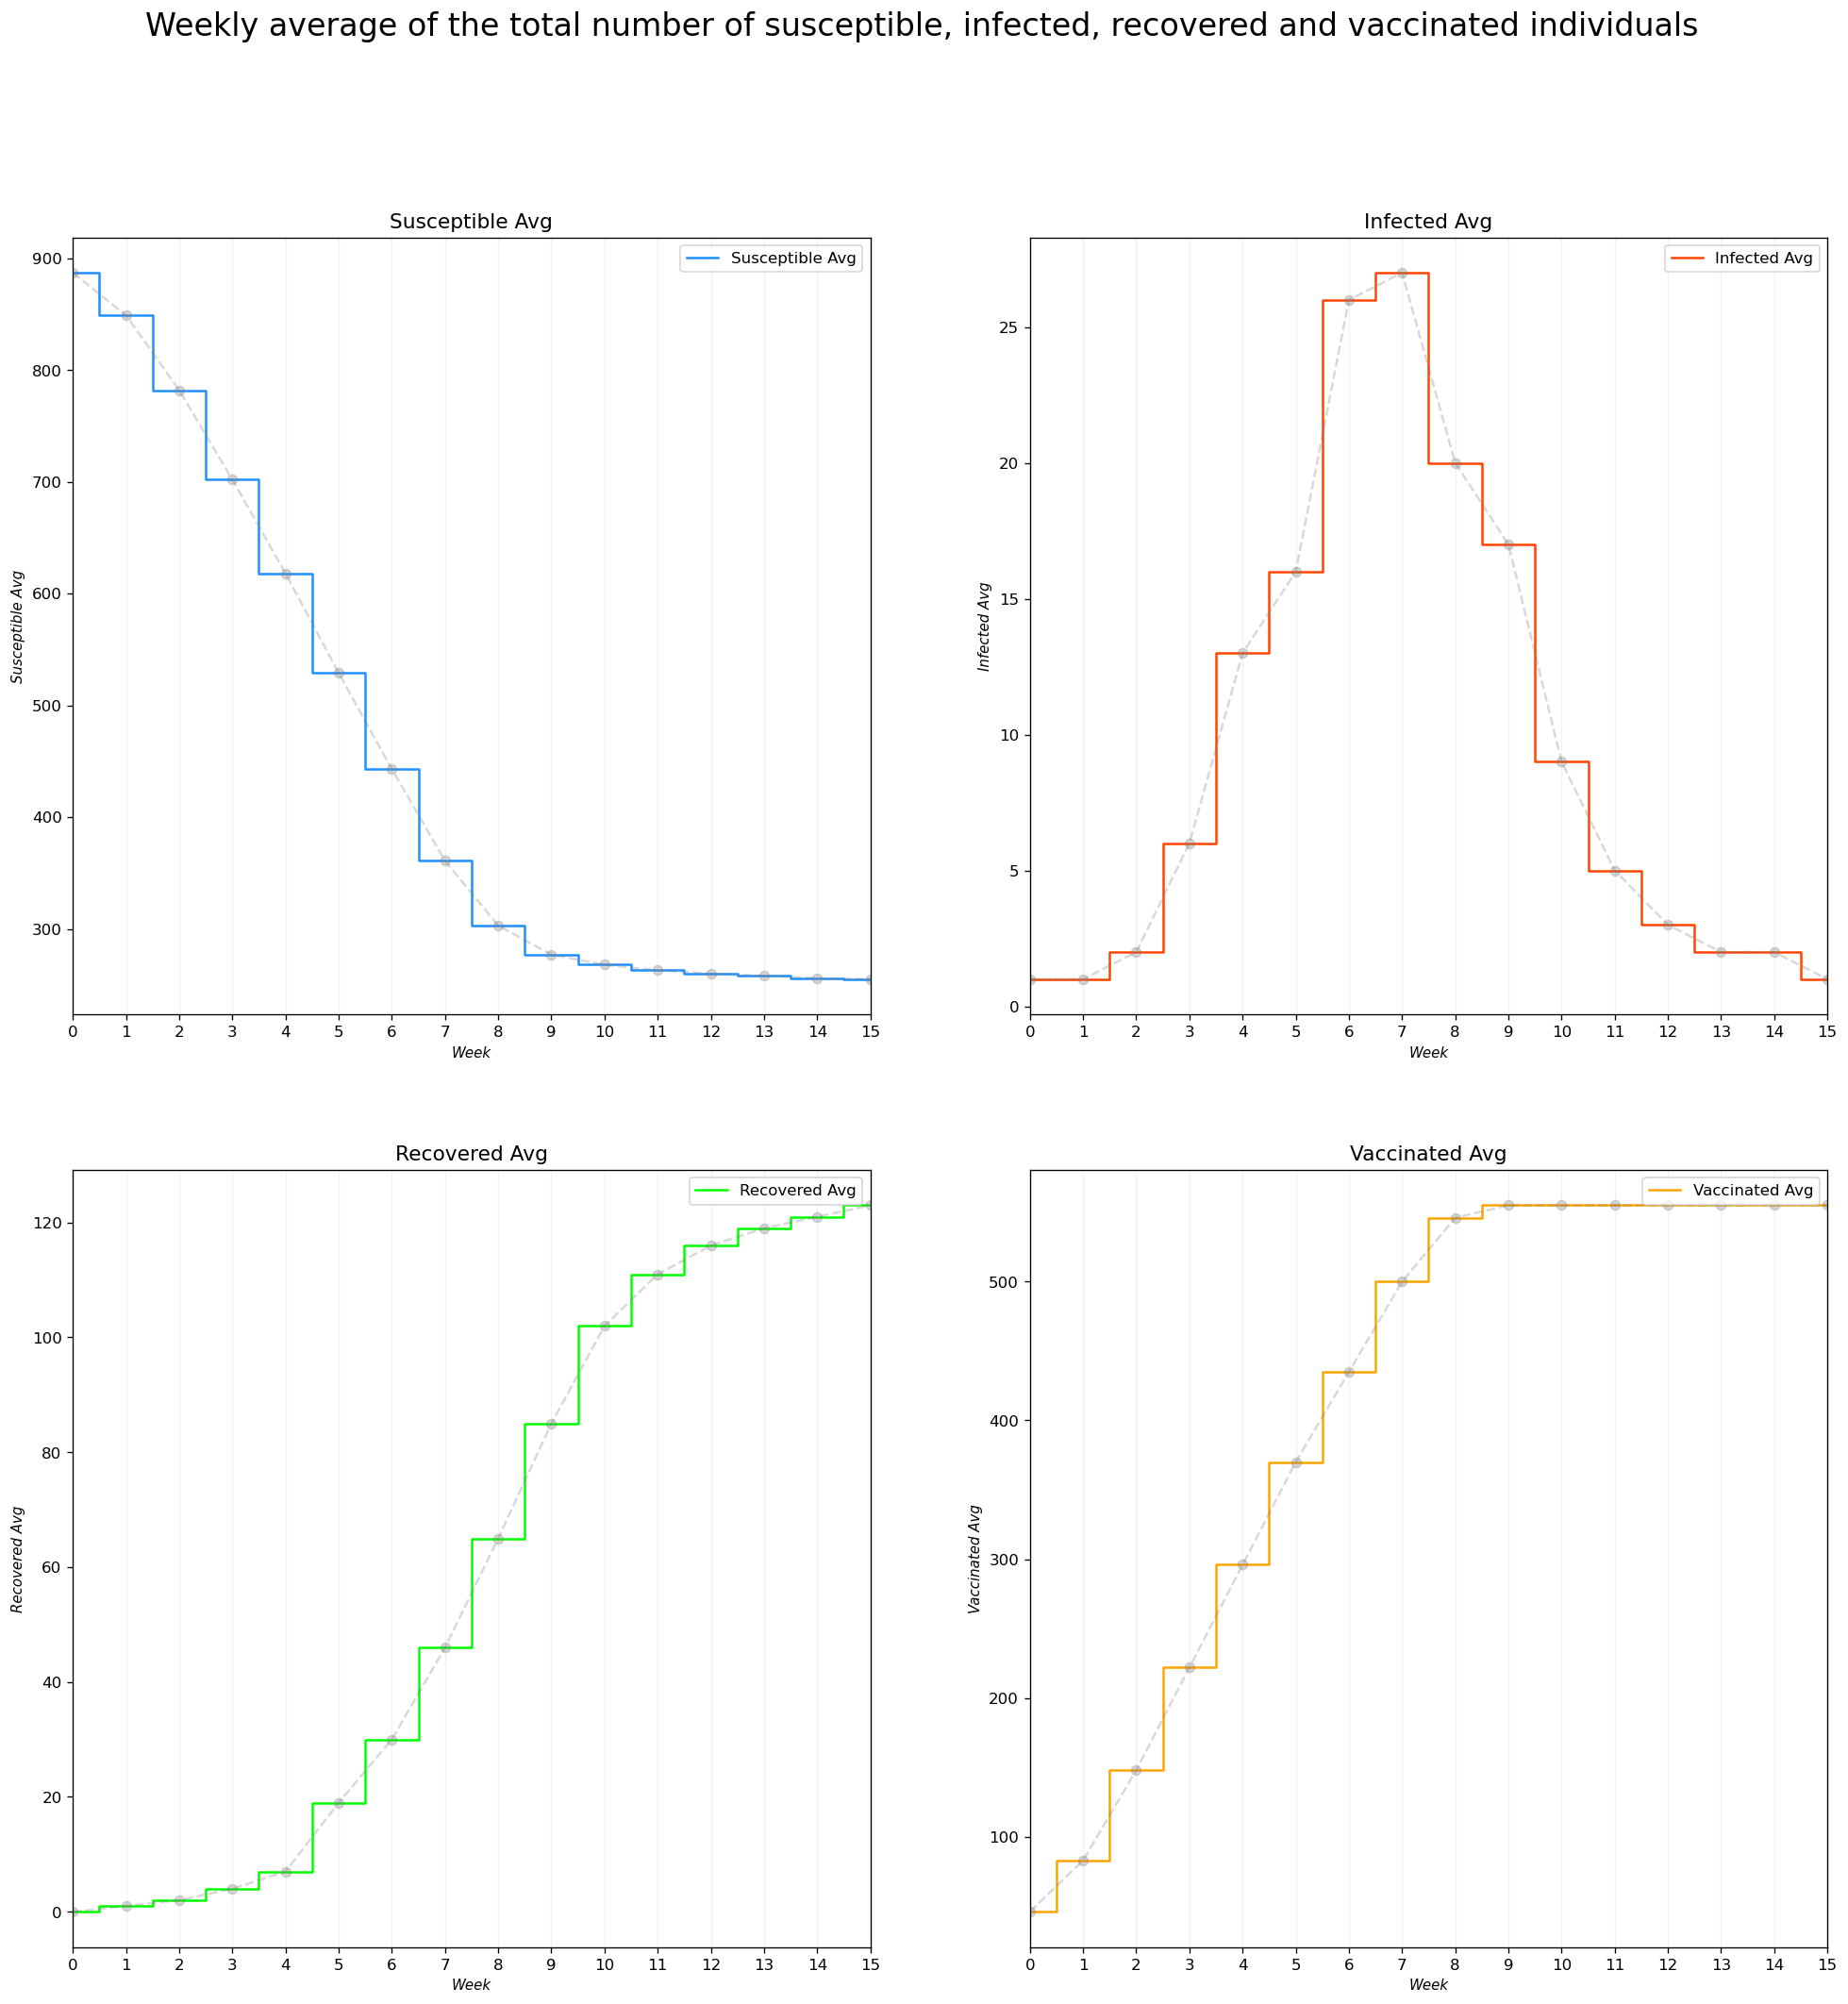

In [229]:
quadruple_plot(18,16, GLOBAL_BEST_epidemic[1],GLOBAL_BEST_epidemic[2],GLOBAL_BEST_epidemic[3],GLOBAL_BEST_epidemic[4])